# Identification and Classification in Urban Canyons in Leeds City Centre

This project aims to create an algorithm capable of automatically finding and characterising urban canyons based on LiDAR images, allowing those with potentially high air pollution to be targeted with interventions. 

In [1]:
#Set Imports

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from openpyxl import Workbook

from pathlib import Path

from sklearn.model_selection import train_test_split

from sklearn.cluster import KMeans

from sklearn_extra.cluster import KMedoids

from sklearn.feature_selection import SelectKBest, chi2, f_regression, f_classif

from sklearn import metrics
from sklearn.metrics import accuracy_score


from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, precision_recall_fscore_support
from sklearn.metrics import classification_report, confusion_matrix
from operator import itemgetter

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight
from sklearn import tree
from sklearn.tree import plot_tree

from sklearn.preprocessing import StandardScaler

import tensorflow as tf
import random as python_random
from numpy.random import RandomState
np.random.seed(12)
python_random.seed(13)

import glob
import cv2

import os
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img,img_to_array, load_img
from keras import regularizers

Using TensorFlow backend.


In [2]:
def summary_d(x):
    
    """ 
        Summary of dataframe
          
        Inputs
        x    name of dataframe
        
    """
    try:
        x.info()       
        x.head()
        x.describe()
     
    except BaseException as e:
        print(e.message)

## Read in data

#### Cross section data

In [71]:
#Read in full file and process
#20 points across each transect
cross_section = pd.read_excel('./data/Output.xlsx',
              dtype={'SAMPLE_1': float })
summary_d(cross_section)


#Keep data for pivot
cross_section_cd =cross_section[[
'fid',             
'distance',
'SAMPLE_1'
]].copy()
cross_section_cd

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213142 entries, 0 to 213141
Data columns (total 35 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   fid         213142 non-null  int64  
 1   pk_0        213142 non-null  int64  
 2   pk          213142 non-null  int64  
 3   fictitious  213142 non-null  bool   
 4   identifier  213142 non-null  object 
 5   class       213142 non-null  object 
 6   roadNumber  42961 non-null   object 
 7   name1       194140 non-null  object 
 8   name1_lang  0 non-null       float64
 9   name2       0 non-null       float64
 10  name2_lang  0 non-null       float64
 11  formOfWay   213142 non-null  object 
 12  length      213142 non-null  int64  
 13  primary     213142 non-null  bool   
 14  trunkRoad   213142 non-null  bool   
 15  loop        213142 non-null  bool   
 16  startNode   213142 non-null  object 
 17  endNode     213142 non-null  object 
 18  structure   4258 non-null    object 
 19  na

,fid,distance,SAMPLE_1
0,1,0,NaN
1,1,1,NaN
2,1,2,NaN
3,1,3,NaN
4,1,4,NaN
...,...,...,...
213137,10397,15,45.896000
213138,10397,16,45.976002
213139,10397,17,46.006001
213140,10397,18,46.030998


In [72]:
#Process data

#if null then 0
cross_section_cd['SAMPLE_1'] = cross_section_cd['SAMPLE_1'] .fillna (0)

#Check NAN now 0
cross_section_cd.head()

#Remove greater than 20.0000000000001
cross_section_2 = cross_section_cd[cross_section_cd['distance'] < 20.000000000000001].copy()

#Round distance to interger
cross_section_2['distance'] = cross_section_2['distance'].apply(np.ceil)

cross_section_2

,fid,distance,SAMPLE_1
0,1,0.0,0.000000
1,1,1.0,0.000000
2,1,2.0,0.000000
3,1,3.0,0.000000
4,1,4.0,0.000000
...,...,...,...
213137,10397,15.0,45.896000
213138,10397,16.0,45.976002
213139,10397,17.0,46.006001
213140,10397,18.0,46.030998


#### Road Infomation

In [4]:
#Road information
road_info = pd.read_excel('./data/Road_Bearing.xlsx')
summary_d(road_info)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10397 entries, 0 to 10396
Data columns (total 30 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   fid            10397 non-null  int64  
 1   pk_0           10397 non-null  int64  
 2   pk             10397 non-null  int64  
 3   fictitious     10397 non-null  bool   
 4   identifier     10397 non-null  object 
 5   class          10397 non-null  object 
 6   roadNumber     2096 non-null   object 
 7   name1          9470 non-null   object 
 8   name1_lang     0 non-null      float64
 9   name2          0 non-null      float64
 10  name2_lang     0 non-null      float64
 11  formOfWay      10397 non-null  object 
 12  length         10397 non-null  int64  
 13  primary        10397 non-null  bool   
 14  trunkRoad      10397 non-null  bool   
 15  loop           10397 non-null  bool   
 16  startNode      10397 non-null  object 
 17  endNode        10397 non-null  object 
 18  struct

## Data Prep

In [5]:
#Transpose cross section data
#https://stackoverflow.com/questions/45596576/python-pandas-proc-transpose-equivalent

In [6]:
Cross_tp = cross_section_2.pivot_table(index=['fid'], columns='distance', aggfunc=sum, fill_value=0)

Cross_tp.columns = ['{}_{}'.format(x[0], x[1]) for x in Cross_tp.columns]
Cross_tp = Cross_tp.reset_index().rename_axis(None, axis=1)
print (Cross_tp)


         fid  SAMPLE_1_0  SAMPLE_1_1  SAMPLE_1_2  SAMPLE_1_3  SAMPLE_1_4  \
0          1    0.000000       0.000    0.000000    0.000000    0.000000   
1          2    0.000000       0.000    0.000000    0.000000    0.000000   
2          3    0.000000       0.000    0.000000    0.000000    0.000000   
3          4    0.000000       0.000    0.000000    0.000000    0.000000   
4          5    0.000000       0.000    0.000000    0.000000    0.000000   
...      ...         ...         ...         ...         ...         ...   
10392  10393   59.542999      60.173   60.535999   59.910999   59.342999   
10393  10394   59.542999      60.173   60.535999   59.910999   59.342999   
10394  10395   45.436001      45.466   45.498001   45.521000   45.556000   
10395  10396   45.436001      45.466   45.498001   45.521000   45.556000   
10396  10397   45.573002      45.591   45.608002   45.632999   45.658001   

       SAMPLE_1_5  SAMPLE_1_6  SAMPLE_1_7  SAMPLE_1_8  ...  SAMPLE_1_RD_11  \
0        

In [7]:
#Merge to road data

In [8]:
Road_tp = pd.merge(road_info,Cross_tp, how='left', on=['fid'],sort=False)
summary_d(Road_tp)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10397 entries, 0 to 10396
Data columns (total 72 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   fid             10397 non-null  int64  
 1   pk_0            10397 non-null  int64  
 2   pk              10397 non-null  int64  
 3   fictitious      10397 non-null  bool   
 4   identifier      10397 non-null  object 
 5   class           10397 non-null  object 
 6   roadNumber      2096 non-null   object 
 7   name1           9470 non-null   object 
 8   name1_lang      0 non-null      float64
 9   name2           0 non-null      float64
 10  name2_lang      0 non-null      float64
 11  formOfWay       10397 non-null  object 
 12  length          10397 non-null  int64  
 13  primary         10397 non-null  bool   
 14  trunkRoad       10397 non-null  bool   
 15  loop            10397 non-null  bool   
 16  startNode       10397 non-null  object 
 17  endNode         10397 non-null 

### Calculations

In [10]:
#Min #max #mode #mean

Road_tp['min_height020'] = Road_tp[['SAMPLE_1_0',
'SAMPLE_1_1',
'SAMPLE_1_2',
'SAMPLE_1_3',
'SAMPLE_1_4',
'SAMPLE_1_5',
'SAMPLE_1_6',
'SAMPLE_1_7',
'SAMPLE_1_8',
'SAMPLE_1_9',
'SAMPLE_1_10',
'SAMPLE_1_11',
'SAMPLE_1_12',
'SAMPLE_1_13',
'SAMPLE_1_14',
'SAMPLE_1_15',
'SAMPLE_1_16',
'SAMPLE_1_17',
'SAMPLE_1_18',
'SAMPLE_1_19',
'SAMPLE_1_20'
]].min(axis=1)

Road_tp['min_height019'] = Road_tp[['SAMPLE_1_0',
'SAMPLE_1_1',
'SAMPLE_1_2',
'SAMPLE_1_3',
'SAMPLE_1_4',
'SAMPLE_1_5',
'SAMPLE_1_6',
'SAMPLE_1_7',
'SAMPLE_1_8',
'SAMPLE_1_9',
'SAMPLE_1_10',
'SAMPLE_1_11',
'SAMPLE_1_12',
'SAMPLE_1_13',
'SAMPLE_1_14',
'SAMPLE_1_15',
'SAMPLE_1_16',
'SAMPLE_1_17',
'SAMPLE_1_18',
'SAMPLE_1_19'
]].min(axis=1)

Road_tp['max_height020'] = Road_tp[['SAMPLE_1_0',
'SAMPLE_1_1',
'SAMPLE_1_2',
'SAMPLE_1_3',
'SAMPLE_1_4',
'SAMPLE_1_5',
'SAMPLE_1_6',
'SAMPLE_1_7',
'SAMPLE_1_8',
'SAMPLE_1_9',
'SAMPLE_1_10',
'SAMPLE_1_11',
'SAMPLE_1_12',
'SAMPLE_1_13',
'SAMPLE_1_14',
'SAMPLE_1_15',
'SAMPLE_1_16',
'SAMPLE_1_17',
'SAMPLE_1_18',
'SAMPLE_1_19',
'SAMPLE_1_20']].max(axis=1)

Road_tp['mean_height020'] = Road_tp[['SAMPLE_1_0',
'SAMPLE_1_1',
'SAMPLE_1_2',
'SAMPLE_1_3',
'SAMPLE_1_4',
'SAMPLE_1_5',
'SAMPLE_1_6',
'SAMPLE_1_7',
'SAMPLE_1_8',
'SAMPLE_1_9',
'SAMPLE_1_10',
'SAMPLE_1_11',
'SAMPLE_1_12',
'SAMPLE_1_13',
'SAMPLE_1_14',
'SAMPLE_1_15',
'SAMPLE_1_16',
'SAMPLE_1_17',
'SAMPLE_1_18',
'SAMPLE_1_19',
'SAMPLE_1_20']].mean(axis=1)




# max 1 to 10
Road_tp['max_height010'] = Road_tp[[
'SAMPLE_1_0',
'SAMPLE_1_1',
'SAMPLE_1_2',
'SAMPLE_1_3',
'SAMPLE_1_4',
'SAMPLE_1_5',
'SAMPLE_1_6',
'SAMPLE_1_7',
'SAMPLE_1_8',
'SAMPLE_1_9',
'SAMPLE_1_10']].max(axis=1)

# max 11 to 20
Road_tp['max_height1120'] = Road_tp[[
'SAMPLE_1_11',
'SAMPLE_1_12',
'SAMPLE_1_13',
'SAMPLE_1_14',
'SAMPLE_1_15',
'SAMPLE_1_16',
'SAMPLE_1_17',
'SAMPLE_1_18',
'SAMPLE_1_19',
'SAMPLE_1_20'
]].max(axis=1)

# max 0 to 7
Road_tp['max_height07'] = Road_tp[[
'SAMPLE_1_0',
'SAMPLE_1_1',
'SAMPLE_1_2',
'SAMPLE_1_3',
'SAMPLE_1_4',
'SAMPLE_1_5',
'SAMPLE_1_6',
'SAMPLE_1_7',
]].max(axis=1)

# max 13 to 20
Road_tp['max_height1320'] = Road_tp[[
'SAMPLE_1_13',
'SAMPLE_1_14',
'SAMPLE_1_15',
'SAMPLE_1_16',
'SAMPLE_1_17',
'SAMPLE_1_18',
'SAMPLE_1_19',
'SAMPLE_1_20'
]].max(axis=1)

# max 0 to 7
Road_tp['mean_height07'] = Road_tp[[
'SAMPLE_1_0',
'SAMPLE_1_1',
'SAMPLE_1_2',
'SAMPLE_1_3',
'SAMPLE_1_4',
'SAMPLE_1_5',
'SAMPLE_1_6',
'SAMPLE_1_7',
]].mean(axis=1)

# max 13 to 20
Road_tp['mean_height1320'] = Road_tp[[
'SAMPLE_1_13',
'SAMPLE_1_14',
'SAMPLE_1_15',
'SAMPLE_1_16',
'SAMPLE_1_17',
'SAMPLE_1_18',
'SAMPLE_1_19',
'SAMPLE_1_20'
]].mean(axis=1)



# min 3 to 17
Road_tp['min_height317'] = Road_tp[[
'SAMPLE_1_3',
'SAMPLE_1_4',
'SAMPLE_1_5',
'SAMPLE_1_6',
'SAMPLE_1_7',
'SAMPLE_1_8',
'SAMPLE_1_9',
'SAMPLE_1_10',
'SAMPLE_1_11',
'SAMPLE_1_12',
'SAMPLE_1_13',
'SAMPLE_1_14',
'SAMPLE_1_15',
'SAMPLE_1_16',
'SAMPLE_1_17'
]].min(axis=1)


Road_tp


,fid,pk_0,pk,fictitious,identifier,class,roadNumber,name1,name1_lang,name2,...,min_height019,max_height020,mean_height020,max_height010,max_height1120,max_height07,max_height1320,mean_height07,mean_height1320,min_height317
0,1,1,1,False,E2174F7F-2A7D-4CD0-B0D6-037719ECFECC,Not Classified,NaN,Clarendon Way,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2,1,1,False,E2174F7F-2A7D-4CD0-B0D6-037719ECFECC,Not Classified,NaN,Clarendon Way,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,3,1,1,False,E2174F7F-2A7D-4CD0-B0D6-037719ECFECC,Not Classified,NaN,Clarendon Way,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,4,1,1,False,E2174F7F-2A7D-4CD0-B0D6-037719ECFECC,Not Classified,NaN,Clarendon Way,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,5,1,1,False,E2174F7F-2A7D-4CD0-B0D6-037719ECFECC,Not Classified,NaN,Clarendon Way,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10392,10393,589,589,False,A7CF867E-68F8-4757-8F3C-8DC8D5D9116B,Unknown,NaN,Lands Lane,NaN,NaN,...,45.585999,65.303001,49.521952,60.535999,65.303001,60.535999,65.303001,55.662999,45.751875,45.585999
10393,10394,589,589,False,A7CF867E-68F8-4757-8F3C-8DC8D5D9116B,Unknown,NaN,Lands Lane,NaN,NaN,...,45.585999,65.303001,49.521952,60.535999,65.303001,60.535999,65.303001,55.662999,45.751875,45.585999
10394,10395,589,589,False,A7CF867E-68F8-4757-8F3C-8DC8D5D9116B,Unknown,NaN,Lands Lane,NaN,NaN,...,45.436001,46.002998,43.556857,45.748001,46.002998,45.673000,46.002998,45.542000,40.194625,45.521000
10395,10396,589,589,False,A7CF867E-68F8-4757-8F3C-8DC8D5D9116B,Unknown,NaN,Lands Lane,NaN,NaN,...,45.436001,46.002998,43.556857,45.748001,46.002998,45.673000,46.002998,45.542000,40.194625,45.521000


In [11]:
#Remove row that have min as 0
Road_tp.drop(Road_tp.loc[Road_tp['min_height019']== 0.0].index, inplace=True)
Road_tp

,fid,pk_0,pk,fictitious,identifier,class,roadNumber,name1,name1_lang,name2,...,min_height019,max_height020,mean_height020,max_height010,max_height1120,max_height07,max_height1320,mean_height07,mean_height1320,min_height317
15,16,1,1,False,E2174F7F-2A7D-4CD0-B0D6-037719ECFECC,Not Classified,NaN,Clarendon Way,NaN,NaN,...,59.061001,61.585999,59.674762,59.612999,61.585999,59.612999,61.585999,59.490125,60.187624,59.061001
16,17,1,1,False,E2174F7F-2A7D-4CD0-B0D6-037719ECFECC,Not Classified,NaN,Clarendon Way,NaN,NaN,...,59.061001,61.585999,56.742095,59.612999,61.585999,59.612999,61.585999,59.490125,52.489375,59.061001
17,18,1,1,False,E2174F7F-2A7D-4CD0-B0D6-037719ECFECC,Not Classified,NaN,Clarendon Way,NaN,NaN,...,58.508999,60.846001,56.443810,59.276001,60.846001,59.276001,60.846001,59.035500,52.318250,58.508999
18,19,1,1,False,E2174F7F-2A7D-4CD0-B0D6-037719ECFECC,Not Classified,NaN,Clarendon Way,NaN,NaN,...,58.508999,65.028999,59.540429,59.276001,65.028999,59.276001,65.028999,59.035500,60.446875,58.508999
19,20,1,1,False,E2174F7F-2A7D-4CD0-B0D6-037719ECFECC,Not Classified,NaN,Clarendon Way,NaN,NaN,...,58.094002,59.868999,55.839809,58.848000,59.868999,58.848000,59.868999,58.591875,51.458999,58.094002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10392,10393,589,589,False,A7CF867E-68F8-4757-8F3C-8DC8D5D9116B,Unknown,NaN,Lands Lane,NaN,NaN,...,45.585999,65.303001,49.521952,60.535999,65.303001,60.535999,65.303001,55.662999,45.751875,45.585999
10393,10394,589,589,False,A7CF867E-68F8-4757-8F3C-8DC8D5D9116B,Unknown,NaN,Lands Lane,NaN,NaN,...,45.585999,65.303001,49.521952,60.535999,65.303001,60.535999,65.303001,55.662999,45.751875,45.585999
10394,10395,589,589,False,A7CF867E-68F8-4757-8F3C-8DC8D5D9116B,Unknown,NaN,Lands Lane,NaN,NaN,...,45.436001,46.002998,43.556857,45.748001,46.002998,45.673000,46.002998,45.542000,40.194625,45.521000
10395,10396,589,589,False,A7CF867E-68F8-4757-8F3C-8DC8D5D9116B,Unknown,NaN,Lands Lane,NaN,NaN,...,45.436001,46.002998,43.556857,45.748001,46.002998,45.673000,46.002998,45.542000,40.194625,45.521000


In [12]:
#Rough canyon calculation 
#height = First + last/2 - middle
Road_tp['C_height020'] = (Road_tp['SAMPLE_1_0'] + Road_tp['SAMPLE_1_20'])/2 - Road_tp['SAMPLE_1_10']

#rough height/20
Road_tp['Canyon020'] = Road_tp['C_height020']/20

#height = (Max 0 - 10)  + (Max 11 - 20) - min middle
Road_tp['C_height010'] = (Road_tp['max_height010'] + Road_tp['max_height1120'])/2 - Road_tp['min_height317']


#Canyon
Road_tp['Canyon010'] = Road_tp['C_height010']/20

Road_tp['MinMaxDiffHeight'] = (Road_tp['max_height020'] - Road_tp['min_height317'])  - (Road_tp['min_height019'] -Road_tp['min_height317'])

Road_tp['DiffHeight'] = abs(Road_tp['max_height07']  - Road_tp['max_height1320'])


Road_tp

,fid,pk_0,pk,fictitious,identifier,class,roadNumber,name1,name1_lang,name2,...,max_height1320,mean_height07,mean_height1320,min_height317,C_height020,Canyon020,C_height010,Canyon010,MinMaxDiffHeight,DiffHeight
15,16,1,1,False,E2174F7F-2A7D-4CD0-B0D6-037719ECFECC,Not Classified,NaN,Clarendon Way,NaN,NaN,...,61.585999,59.490125,60.187624,59.061001,1.454998,0.072750,1.538498,0.076925,2.524998,1.973000
16,17,1,1,False,E2174F7F-2A7D-4CD0-B0D6-037719ECFECC,Not Classified,NaN,Clarendon Way,NaN,NaN,...,61.585999,59.490125,52.489375,59.061001,-29.338001,-1.466900,1.538498,0.076925,2.524998,1.973000
17,18,1,1,False,E2174F7F-2A7D-4CD0-B0D6-037719ECFECC,Not Classified,NaN,Clarendon Way,NaN,NaN,...,60.846001,59.035500,52.318250,58.508999,-28.999498,-1.449975,1.552002,0.077600,2.337002,1.570000
18,19,1,1,False,E2174F7F-2A7D-4CD0-B0D6-037719ECFECC,Not Classified,NaN,Clarendon Way,NaN,NaN,...,65.028999,59.035500,60.446875,58.508999,3.515001,0.175750,3.643501,0.182175,6.520000,5.752998
19,20,1,1,False,E2174F7F-2A7D-4CD0-B0D6-037719ECFECC,Not Classified,NaN,Clarendon Way,NaN,NaN,...,59.868999,58.591875,51.458999,58.094002,-29.095001,-1.454750,1.264498,0.063225,1.774998,1.021000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10392,10393,589,589,False,A7CF867E-68F8-4757-8F3C-8DC8D5D9116B,Unknown,NaN,Lands Lane,NaN,NaN,...,65.303001,55.662999,45.751875,45.585999,-15.906502,-0.795325,17.333502,0.866675,19.717003,4.767002
10393,10394,589,589,False,A7CF867E-68F8-4757-8F3C-8DC8D5D9116B,Unknown,NaN,Lands Lane,NaN,NaN,...,65.303001,55.662999,45.751875,45.585999,-15.906502,-0.795325,17.333502,0.866675,19.717003,4.767002
10394,10395,589,589,False,A7CF867E-68F8-4757-8F3C-8DC8D5D9116B,Unknown,NaN,Lands Lane,NaN,NaN,...,46.002998,45.542000,40.194625,45.521000,-23.030001,-1.151500,0.354500,0.017725,0.566998,0.329998
10395,10396,589,589,False,A7CF867E-68F8-4757-8F3C-8DC8D5D9116B,Unknown,NaN,Lands Lane,NaN,NaN,...,46.002998,45.542000,40.194625,45.521000,-23.030001,-1.151500,0.354500,0.017725,0.566998,0.329998


In [13]:
#Export to Excel to look at
Road_tp.to_csv (r'./data/output_canyons.csv', index = False, header=True)

In [14]:
#Remove Canyon010 less than 0.5
Canyons = Road_tp[Road_tp['Canyon010'] >= 0.5].copy()

Canyons

,fid,pk_0,pk,fictitious,identifier,class,roadNumber,name1,name1_lang,name2,...,max_height1320,mean_height07,mean_height1320,min_height317,C_height020,Canyon020,C_height010,Canyon010,MinMaxDiffHeight,DiffHeight
22,23,1,1,False,E2174F7F-2A7D-4CD0-B0D6-037719ECFECC,Not Classified,NaN,Clarendon Way,NaN,NaN,...,58.580002,72.048124,50.607501,57.326000,-12.470001,-0.623500,16.820000,0.841000,32.385998,31.131996
23,24,1,1,False,E2174F7F-2A7D-4CD0-B0D6-037719ECFECC,Not Classified,NaN,Clarendon Way,NaN,NaN,...,58.580002,72.048124,50.607501,57.326000,-12.470001,-0.623500,16.820000,0.841000,32.385998,31.131996
24,25,1,1,False,E2174F7F-2A7D-4CD0-B0D6-037719ECFECC,Not Classified,NaN,Clarendon Way,NaN,NaN,...,58.769001,72.786000,57.841250,57.188000,17.461500,0.873075,17.472502,0.873625,33.364002,31.783001
25,26,1,1,False,E2174F7F-2A7D-4CD0-B0D6-037719ECFECC,Not Classified,NaN,Clarendon Way,NaN,NaN,...,58.362000,73.037875,50.433875,57.109001,-11.645000,-0.582250,17.549999,0.877500,33.847000,32.594002
26,27,1,1,False,E2174F7F-2A7D-4CD0-B0D6-037719ECFECC,Not Classified,NaN,Clarendon Way,NaN,NaN,...,57.799000,73.496125,49.951876,56.653999,-11.188000,-0.559400,17.719500,0.885975,34.293999,33.148998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10389,10390,589,589,False,A7CF867E-68F8-4757-8F3C-8DC8D5D9116B,Unknown,NaN,Lands Lane,NaN,NaN,...,66.791000,55.732125,56.194749,45.368000,17.708498,0.885425,18.278000,0.913900,21.423000,6.290001
10390,10391,589,589,False,A7CF867E-68F8-4757-8F3C-8DC8D5D9116B,Unknown,NaN,Lands Lane,NaN,NaN,...,66.791000,55.071375,57.303624,45.401001,17.748499,0.887425,18.244999,0.912250,21.389999,6.290001
10391,10392,589,589,False,A7CF867E-68F8-4757-8F3C-8DC8D5D9116B,Unknown,NaN,Lands Lane,NaN,NaN,...,65.941002,56.122625,48.072000,45.557999,-15.929499,-0.796475,17.660501,0.883025,20.383003,5.445004
10392,10393,589,589,False,A7CF867E-68F8-4757-8F3C-8DC8D5D9116B,Unknown,NaN,Lands Lane,NaN,NaN,...,65.303001,55.662999,45.751875,45.585999,-15.906502,-0.795325,17.333502,0.866675,19.717003,4.767002


## Clustering C_height010  DiffHeight 

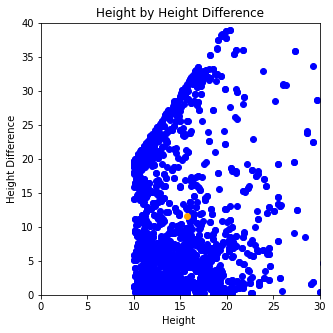

In [15]:
#Cluster C_height010  DiffHeight 

Canyons_cluster =Canyons[[
'C_height010',             
'DiffHeight'                   
]]

clus_C = Canyons_cluster.dropna()

kmeans =KMeans(n_clusters =1)
kmeans.fit(clus_C)

labels = kmeans.predict(clus_C)
centroids =kmeans.cluster_centers_

fig =plt.figure(figsize=(5,5))
#color =map(lambda x: colmap[x +1],labels)

plt.scatter(clus_C['C_height010'], clus_C['DiffHeight'], color ='blue')
plt.xlim(0,30)
plt.ylim(0,40)
plt.xlabel('Height ') 
plt.ylabel('Height Difference') 
plt.title('Height by Height Difference') 
results_path = 'Height by Height Difference Canyon.png'

plt.scatter(centroids[:,0],centroids [:,1],color ='orange')
plt.savefig(results_path,bbox_inches="tight")
plt.show()

In [16]:
#Split into 4 groups
#high both sides over 15 meters and less than 10 meter height difference HH
#Low both sides Both sides less than 15 and less than 10 meter height difference ll
#High one side H 
#Low one side L


In [17]:
Canyons['Canyon_HH'] = np.where(((Canyons['C_height010'] >= 15) & (Canyons['DiffHeight'] <= 10)),1,0) #Over15 less 10gap
Canyons['Canyon_LL'] = np.where(((Canyons['C_height010'] < 15) & (Canyons['DiffHeight'] <= 10)),1,0) #Less15 less 10gap
Canyons['Canyon_H'] = np.where(((Canyons['C_height010'] >= 15) & (Canyons['DiffHeight'] > 10)),1,0) #Over15 greater 10gap
Canyons['Canyon_L'] = np.where(((Canyons['C_height010'] < 15) & (Canyons['DiffHeight'] > 10)),1,0) #Less15 greater 10gap

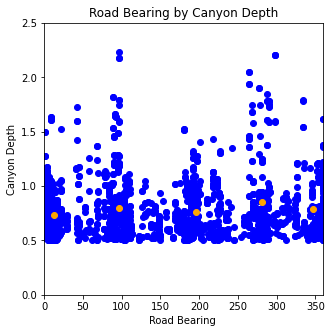

In [18]:
#Cluster RdInfoBearin  Canyon010

Canyons_clus =Canyons[[
'RdInfoBearing',             
'Canyon010'                   
]]

clus = Canyons_clus.dropna()

kmeans =KMeans(n_clusters =5)
kmeans.fit(clus)

labels = kmeans.predict(clus)
centroids =kmeans.cluster_centers_

fig =plt.figure(figsize=(5,5))

plt.scatter(clus['RdInfoBearing'], clus['Canyon010'], color ='blue')
plt.xlim(0,360)
plt.ylim(0,2.5)
plt.xlabel('Road Bearing ') 
plt.ylabel('Canyon Depth') 
plt.title('Road Bearing by Canyon Depth') 
results_path = 'Road Bearing by Canyon Depth.png'

plt.scatter(centroids[:,0],centroids [:,1],color ='orange')
plt.savefig(results_path,bbox_inches="tight")
plt.show()

In [19]:
#Export to Excel to look at
Canyons.to_csv (r'./data/output_canyons2.csv', index = False, header=True)

In [20]:
#Check  volumes
pd.crosstab(index=Canyons['Canyon_HH'], columns='count')

col_0,count
Canyon_HH,
0,1646
1,591


In [21]:
pd.crosstab(index=Canyons['Canyon_LL'], columns='count')

col_0,count
Canyon_LL,
0,1517
1,720


In [22]:
pd.crosstab(index=Canyons['Canyon_H'], columns='count')

col_0,count
Canyon_H,
0,1836
1,401


In [23]:
pd.crosstab(index=Canyons['Canyon_L'], columns='count')


col_0,count
Canyon_L,
0,1712
1,525


In [24]:
#Individual datasets

Canyons_L = Canyons[Canyons['Canyon_L'] == 1].copy()


Canyons_LL = Canyons[Canyons['Canyon_LL'] == 1].copy()


Canyons_H = Canyons[Canyons['Canyon_H'] == 1].copy()


Canyons_HH = Canyons[Canyons['Canyon_HH'] == 1].copy()


## Canyon data outputed in Excel to map canyons in Qgis

In [25]:
#Read in XY data
XY = pd.read_excel('./data/Output_Road_XY.xlsx')
summary_d(XY)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213142 entries, 0 to 213141
Data columns (total 35 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   fid         213142 non-null  int64  
 1   pk_0        213142 non-null  int64  
 2   pk          213142 non-null  int64  
 3   fictitious  213142 non-null  bool   
 4   identifier  213142 non-null  object 
 5   class       213142 non-null  object 
 6   roadNumber  42961 non-null   object 
 7   name1       194140 non-null  object 
 8   name1_lang  0 non-null       float64
 9   name2       0 non-null       float64
 10  name2_lang  0 non-null       float64
 11  formOfWay   213142 non-null  object 
 12  length      213142 non-null  int64  
 13  primary     213142 non-null  bool   
 14  trunkRoad   213142 non-null  bool   
 15  loop        213142 non-null  bool   
 16  startNode   213142 non-null  object 
 17  endNode     213142 non-null  object 
 18  structure   4258 non-null    object 
 19  na

In [26]:
#Merge to Canyon data
canyons_xy = pd.merge(Canyons,XY, how='inner', on=['fid'],sort=False)
summary_d(canyons_xy)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45942 entries, 0 to 45941
Columns: 127 entries, fid to SAMPLE_1
dtypes: bool(8), float64(52), int32(4), int64(41), object(22)
memory usage: 41.7+ MB


In [27]:
canyons_xy_cd =canyons_xy[[
'fid',             
'x',
'y'
# 'Canyon_HH',
# 'Canyon_LL',
# 'Canyon_H', 
# 'Canyon_L', 
]]

In [28]:
#Output all data
#Export to Excel to look at
canyons_xy_cd.to_csv (r'./data/canyons_xy_cd.csv', index = False, header=True)

In [29]:
#Canyons_HH
#Merge to Canyon data
Canyons_HH_xy = pd.merge(Canyons_HH,XY, how='inner', on=['fid'],sort=False)

Canyons_HH_xy_cd =Canyons_HH_xy[[
'fid',             
'x',
'y'
]]

#Output
#Export to Excel to look at
Canyons_HH_xy_cd.to_csv (r'./data/Canyons_HH_xy_cd.csv', index = False, header=True)

In [30]:
#Canyons_LL
#Merge to Canyon data
Canyon_LL_xy = pd.merge(Canyons_LL,XY, how='inner', on=['fid'],sort=False)

Canyon_LL_xy_cd =Canyon_LL_xy[[
'fid',             
'x',
'y'
]]

#Output
#Export to Excel to look at
Canyon_LL_xy_cd.to_csv (r'./data/Canyon_LL_xy_cd.csv', index = False, header=True)

In [31]:
#Canyons_H
#Merge to Canyon data
Canyons_H_xy = pd.merge(Canyons_H,XY, how='inner', on=['fid'],sort=False)

Canyons_H_xy_cd =Canyons_H_xy[[
'fid',             
'x',
'y'
]]

#Output
#Export to Excel to look at
Canyons_H_xy_cd.to_csv (r'./data/Canyons_H_xy_cd.csv', index = False, header=True)

In [32]:
#Canyons_L
#Merge to Canyon data
Canyon_L_xy = pd.merge(Canyons_L,XY, how='inner', on=['fid'],sort=False)

Canyon_L_xy_cd =Canyon_L_xy[[
'fid',             
'x',
'y'
]]

#Output
#Export to Excel to look at
Canyon_L_xy_cd.to_csv (r'./data/Canyon_L_xy_cd.csv', index = False, header=True)

## Convolutional Neural Network(CNN) First model with Leeds City Centre data

In [33]:
#Set locations of data
train_dir = './Output Image/grid/train/'
validate_dir = './Output Image/grid/validation/'

#Train
train_ncy_dir = os.path.join(train_dir, 'ncy')
train_cy_dir = os.path.join(train_dir, 'cy')

#Validation
validate_ncy_dir = os.path.join(validate_dir, 'ncy')
validate_cy_dir = os.path.join(validate_dir, 'cy')

In [34]:
num_ncy_train = len(os.listdir(train_ncy_dir))
num_cy_train = len(os.listdir(train_cy_dir))

num_ncy_validate = len(os.listdir(validate_ncy_dir))
num_cy_validate = len(os.listdir(validate_cy_dir))

train_total = num_ncy_train + num_cy_train
validate_total = num_ncy_validate + num_cy_validate

#Print numbers
print(train_total)
print(validate_total)

2880
720


In [35]:
#Model parameters
batch_size = 32
img_height = 100
img_width = 100

In [36]:
#Model parameters
img_generator = ImageDataGenerator(rescale=1./255)

In [37]:
#Get images for model
train_img_generator =img_generator.flow_from_directory(color_mode ='rgb', batch_size=batch_size,directory=train_dir,shuffle=True,target_size=(img_height,img_width),class_mode='binary',seed=42)

validate_img_generator =img_generator.flow_from_directory(color_mode ='rgb',batch_size=batch_size,directory=validate_dir,shuffle=False,
 target_size=(img_height,img_width),
 class_mode='binary',seed=42)

Found 2880 images belonging to 2 classes.
Found 720 images belonging to 2 classes.


In [38]:
#model components

#Initial model
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(img_height, img_width, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))


In [39]:
#Compile the Model
model.compile(loss = 'binary_crossentropy',
 optimizer = 'adam',
 metrics = ['accuracy'])



In [40]:
#Run model
epochs = 40
fit_result = model.fit_generator(train_img_generator,
 steps_per_epoch=int(np.ceil(train_total / float(batch_size))),
 epochs=epochs,
 validation_data=validate_img_generator,
 validation_steps=int(np.ceil(validate_total / float(batch_size))),
 class_weight=dict(enumerate([num_cy_train,num_ncy_train]))    
                                 )

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/40
90/90 [==============================] - 36s 405ms/step - loss: 961.2064 - accuracy: 0.5351 - val_loss: 0.6704 - val_accuracy: 0.5389
Epoch 2/40
90/90 [==============================] - 33s 362ms/step - loss: 956.2543 - accuracy: 0.5365 - val_loss: 0.6667 - val_accuracy: 0.5389
Epoch 3/40
90/90 [==============================] - 33s 366ms/step - loss: 938.5732 - accuracy: 0.5510 - val_loss: 0.6580 - val_accuracy: 0.5556
Epoch 4/40
90/90 [==============================] - 33s 363ms/step - loss: 921.0834 - accuracy: 0.6090 - val_loss: 0.6534 - val_accuracy: 0.5750
Epoch 5/40
90/90 [==============================] - 33s 365ms/step - loss: 905.4478 - accuracy: 0.6104 - val_loss: 0.6659 - val_accuracy: 0.5319
Epoch 6/40
90/90 [==============================] - 32s 360ms/step - loss: 893.0995 - accuracy: 0.6128 - val_loss: 0.6544 - val_accuracy: 0.6000
Epoch 7/40
90/90 [==============================] - 33

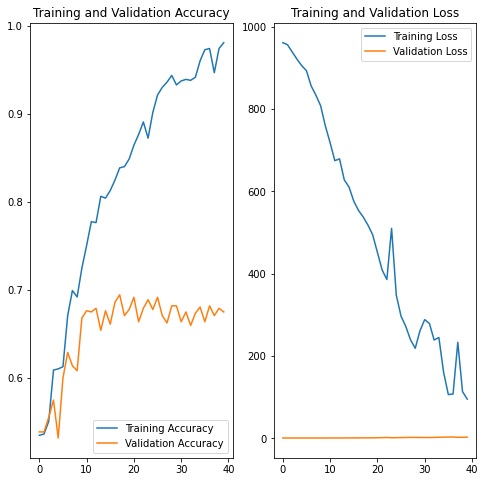

In [41]:
#Graph Accuracy and Loss
acc = fit_result.history['accuracy']
val_acc = fit_result.history['val_accuracy']

loss = fit_result.history['loss']
val_loss = fit_result.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Instructions for updating:
Please use Model.predict, which supports generators.
Confusion Matrix
Classification Report
              precision    recall  f1-score   support

           0       0.63      0.73      0.67       332
           1       0.73      0.63      0.68       388

    accuracy                           0.68       720
   macro avg       0.68      0.68      0.67       720
weighted avg       0.68      0.68      0.68       720

Print stats
Sensitivity 0.63
Specificity 0.73
Overall accuracy 0.68


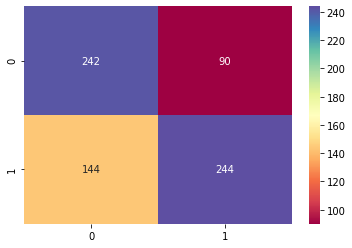

In [42]:
#Validation
Y_pred = model.predict_generator(validate_img_generator, validate_total // batch_size+1)
y_pred = np.where(Y_pred>0.5, 1, 0)
print('Confusion Matrix')
cm = metrics.confusion_matrix(validate_img_generator.classes, y_pred)
# print(cm)

#Picture
sns.heatmap(cm, annot=True, fmt = "d", cmap="Spectral")
results_path = './CM_Base.png'
plt.savefig(results_path)

print('Classification Report')
print(metrics.classification_report(validate_img_generator.classes, y_pred))

print('Print stats')

TN = cm[0][0]
FN = cm[1][0]
TP = cm[1][1]
FP = cm[0][1]


# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)

print('Sensitivity', "%.2f"%TPR)
print('Specificity',"%.2f"%TNR)
print('Overall accuracy', "%.2f"%ACC)


## Process additional Leeds data

In [61]:
#Data
# Sample_1 to float
cross_section_ooa  = pd.read_excel('./data/All_LeedsRd_Output_A.xlsx',
              dtype={'SAMPLE_1': float })  

cross_section_ooa

,fictitious,identifier,class,roadNumber,name1,name1_lang,name2,name2_lang,formOfWay,length,...,TR_SEGMENT,TR_ANGLE,TR_LENGTH,TR_ORIENT,Bearing,org_fid,distance,x,y,SAMPLE_1
0,False,67B2CB9C-6B28-4FBC-BC2A-529C4B366C95,Not Classified,NaN,St John's Grove,NaN,NaN,NaN,Single Carriageway,136,...,1,90,20,2,207.130475,0,0.0,428814.560180,434733.899706,NaN
1,False,67B2CB9C-6B28-4FBC-BC2A-529C4B366C95,Not Classified,NaN,St John's Grove,NaN,NaN,NaN,Single Carriageway,136,...,1,90,20,2,207.130475,0,1.0,428814.104162,434733.009735,NaN
2,False,67B2CB9C-6B28-4FBC-BC2A-529C4B366C95,Not Classified,NaN,St John's Grove,NaN,NaN,NaN,Single Carriageway,136,...,1,90,20,2,207.130475,0,2.0,428813.648144,434732.119765,NaN
3,False,67B2CB9C-6B28-4FBC-BC2A-529C4B366C95,Not Classified,NaN,St John's Grove,NaN,NaN,NaN,Single Carriageway,136,...,1,90,20,2,207.130475,0,3.0,428813.192126,434731.229794,NaN
4,False,67B2CB9C-6B28-4FBC-BC2A-529C4B366C95,Not Classified,NaN,St John's Grove,NaN,NaN,NaN,Single Carriageway,136,...,1,90,20,2,207.130475,0,4.0,428812.736108,434730.339823,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1260702,False,33E68683-1114-43F1-AA7E-10E37CD379FF,Unclassified,NaN,Cable Place,NaN,NaN,NaN,Single Carriageway,141,...,2,90,20,2,72.693330,58652,16.0,431567.768355,431793.324922,24.882000
1260703,False,33E68683-1114-43F1-AA7E-10E37CD379FF,Unclassified,NaN,Cable Place,NaN,NaN,NaN,Single Carriageway,141,...,2,90,20,2,72.693330,58652,17.0,431568.723081,431793.622409,24.898001
1260704,False,33E68683-1114-43F1-AA7E-10E37CD379FF,Unclassified,NaN,Cable Place,NaN,NaN,NaN,Single Carriageway,141,...,2,90,20,2,72.693330,58652,18.0,431569.677807,431793.919896,25.257000
1260705,False,33E68683-1114-43F1-AA7E-10E37CD379FF,Unclassified,NaN,Cable Place,NaN,NaN,NaN,Single Carriageway,141,...,2,90,20,2,72.693330,58652,19.0,431570.632533,431794.217383,26.747000


In [62]:
#Keep data for pivot
cross_section_ooa_cd =cross_section_ooa[[
'fid',             
'distance',
'SAMPLE_1'
]].copy()
cross_section_ooa_cd

,fid,distance,SAMPLE_1
0,0,0.0,NaN
1,0,1.0,NaN
2,0,2.0,NaN
3,0,3.0,NaN
4,0,4.0,NaN
...,...,...,...
1260702,25833,16.0,24.882000
1260703,25833,17.0,24.898001
1260704,25833,18.0,25.257000
1260705,25833,19.0,26.747000


In [63]:
#Keep XY
CanyonXY =cross_section_ooa[[
'fid',   
'pk',  
'x',
'y'
]].copy()
CanyonXY

,fid,pk,x,y
0,0,0,428814.560180,434733.899706
1,0,0,428814.104162,434733.009735
2,0,0,428813.648144,434732.119765
3,0,0,428813.192126,434731.229794
4,0,0,428812.736108,434730.339823
...,...,...,...,...
1260702,25833,3380,431567.768355,431793.324922
1260703,25833,3380,431568.723081,431793.622409
1260704,25833,3380,431569.677807,431793.919896
1260705,25833,3380,431570.632533,431794.217383


In [64]:
#Cross section data
road_info_ooa = pd.read_excel('./data/All_Leeds_10mA.xlsx')
summary_d(road_info_ooa)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25834 entries, 0 to 25833
Data columns (total 22 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   fictitious  25834 non-null  bool   
 1   identifier  25834 non-null  object 
 2   class       25834 non-null  object 
 3   roadNumber  5109 non-null   object 
 4   name1       22706 non-null  object 
 5   name1_lang  0 non-null      float64
 6   name2       0 non-null      float64
 7   name2_lang  0 non-null      float64
 8   formOfWay   25834 non-null  object 
 9   length      25834 non-null  int64  
 10  primary     25834 non-null  bool   
 11  trunkRoad   25834 non-null  bool   
 12  loop        25834 non-null  bool   
 13  startNode   25834 non-null  object 
 14  endNode     25834 non-null  object 
 15  structure   93 non-null     object 
 16  nameTOID    22706 non-null  object 
 17  numberTOID  5109 non-null   object 
 18  function    25834 non-null  object 
 19  pk          25834 non-nul

In [65]:
#Process data cross section

#if null then 0
cross_section_ooa_cd['SAMPLE_1'] = cross_section_ooa_cd['SAMPLE_1'] .fillna (0)

#Check NAN now 0
cross_section_ooa_cd.head()

#Remove greater than 20.0000000000001
cross_section_ooa2 = cross_section_ooa_cd[cross_section_ooa_cd['distance'] < 20.000000000000001].copy()

#Round distance to interger
cross_section_ooa2['distance'] = cross_section_ooa2['distance'].apply(np.ceil)

cross_section_ooa2


,fid,distance,SAMPLE_1
0,0,0.0,0.0
1,0,1.0,0.0
2,0,2.0,0.0
3,0,3.0,0.0
4,0,4.0,0.0


In [67]:
#Remove greater than 20.0000000000001
cross_section_ooa2 = cross_section_ooa_cd[cross_section_ooa_cd['distance'] < 20.000000000000001].copy()

#Round distance to interger
cross_section_ooa2['distance'] = cross_section_ooa2['distance'].apply(np.ceil)

cross_section_ooa2

,fid,distance,SAMPLE_1
0,0,0.0,0.000000
1,0,1.0,0.000000
2,0,2.0,0.000000
3,0,3.0,0.000000
4,0,4.0,0.000000
...,...,...,...
1260702,25833,16.0,24.882000
1260703,25833,17.0,24.898001
1260704,25833,18.0,25.257000
1260705,25833,19.0,26.747000


In [68]:
#Check volumes
pd.crosstab(index=cross_section_ooa2['distance'], columns='count')

col_0,count
distance,
0.0,58653
1.0,58653
2.0,58653
3.0,58653
4.0,58653
5.0,58653
6.0,58653
7.0,58653
8.0,58653


In [69]:
#Transpose data
Cross_tp_ooa = cross_section_ooa2.pivot_table(index=['fid'], columns='distance', aggfunc=sum, fill_value=0)

Cross_tp_ooa.columns = ['{}_{}'.format(x[0], x[1]) for x in Cross_tp_ooa.columns]
Cross_tp_ooa = Cross_tp_ooa.reset_index().rename_axis(None, axis=1)
summary_d(Cross_tp_ooa)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25834 entries, 0 to 25833
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   fid            25834 non-null  int64  
 1   SAMPLE_1_0.0   25834 non-null  float64
 2   SAMPLE_1_1.0   25834 non-null  float64
 3   SAMPLE_1_2.0   25834 non-null  float64
 4   SAMPLE_1_3.0   25834 non-null  float64
 5   SAMPLE_1_4.0   25834 non-null  float64
 6   SAMPLE_1_5.0   25834 non-null  float64
 7   SAMPLE_1_6.0   25834 non-null  float64
 8   SAMPLE_1_7.0   25834 non-null  float64
 9   SAMPLE_1_8.0   25834 non-null  float64
 10  SAMPLE_1_9.0   25834 non-null  float64
 11  SAMPLE_1_10.0  25834 non-null  float64
 12  SAMPLE_1_11.0  25834 non-null  float64
 13  SAMPLE_1_12.0  25834 non-null  float64
 14  SAMPLE_1_13.0  25834 non-null  float64
 15  SAMPLE_1_14.0  25834 non-null  float64
 16  SAMPLE_1_15.0  25834 non-null  float64
 17  SAMPLE_1_16.0  25834 non-null  float64
 18  SAMPLE

In [70]:
#Merge
Road_tp_ooa = pd.merge(road_info_ooa,Cross_tp_ooa, how='left', on=['fid'],sort=False)


#Min #max #mode #mean
Road_tp_ooa['min_height020'] = Road_tp_ooa[['SAMPLE_1_0.0',
'SAMPLE_1_1.0',
'SAMPLE_1_2.0',
'SAMPLE_1_3.0',
'SAMPLE_1_4.0',
'SAMPLE_1_5.0',
'SAMPLE_1_6.0',
'SAMPLE_1_7.0',
'SAMPLE_1_8.0',
'SAMPLE_1_9.0',
'SAMPLE_1_10.0',
'SAMPLE_1_11.0',
'SAMPLE_1_12.0',
'SAMPLE_1_13.0',
'SAMPLE_1_14.0',
'SAMPLE_1_15.0',
'SAMPLE_1_16.0',
'SAMPLE_1_17.0',
'SAMPLE_1_18.0',
'SAMPLE_1_19.0',
'SAMPLE_1_20.0'
]].min(axis=1)

Road_tp_ooa['min_height019'] = Road_tp_ooa[['SAMPLE_1_0.0',
'SAMPLE_1_1.0',
'SAMPLE_1_2.0',
'SAMPLE_1_3.0',
'SAMPLE_1_4.0',
'SAMPLE_1_5.0',
'SAMPLE_1_6.0',
'SAMPLE_1_7.0',
'SAMPLE_1_8.0',
'SAMPLE_1_9.0',
'SAMPLE_1_10.0',
'SAMPLE_1_11.0',
'SAMPLE_1_12.0',
'SAMPLE_1_13.0',
'SAMPLE_1_14.0',
'SAMPLE_1_15.0',
'SAMPLE_1_16.0',
'SAMPLE_1_17.0',
'SAMPLE_1_18.0',
'SAMPLE_1_19.0'
]].min(axis=1)

Road_tp_ooa['max_height020'] = Road_tp_ooa[['SAMPLE_1_0.0',
'SAMPLE_1_1.0',
'SAMPLE_1_2.0',
'SAMPLE_1_3.0',
'SAMPLE_1_4.0',
'SAMPLE_1_5.0',
'SAMPLE_1_6.0',
'SAMPLE_1_7.0',
'SAMPLE_1_8.0',
'SAMPLE_1_9.0',
'SAMPLE_1_10.0',
'SAMPLE_1_11.0',
'SAMPLE_1_12.0',
'SAMPLE_1_13.0',
'SAMPLE_1_14.0',
'SAMPLE_1_15.0',
'SAMPLE_1_16.0',
'SAMPLE_1_17.0',
'SAMPLE_1_18.0',
'SAMPLE_1_19.0',
'SAMPLE_1_20.0']].max(axis=1)

# Road_tp['mean_height020'] = Road_tp[['SAMPLE_1_0',
# 'SAMPLE_1_1',
# 'SAMPLE_1_2',
# 'SAMPLE_1_3',
# 'SAMPLE_1_4',
# 'SAMPLE_1_5',
# 'SAMPLE_1_6',
# 'SAMPLE_1_7',
# 'SAMPLE_1_8',
# 'SAMPLE_1_9',
# 'SAMPLE_1_10',
# 'SAMPLE_1_11',
# 'SAMPLE_1_12',
# 'SAMPLE_1_13',
# 'SAMPLE_1_14',
# 'SAMPLE_1_15',
# 'SAMPLE_1_16',
# 'SAMPLE_1_17',
# 'SAMPLE_1_18',
# 'SAMPLE_1_19',
# 'SAMPLE_1_20']].mean(axis=1)




# max 1 to 10
Road_tp_ooa['max_height010'] = Road_tp_ooa[[
'SAMPLE_1_0.0',
'SAMPLE_1_1.0',
'SAMPLE_1_2.0',
'SAMPLE_1_3.0',
'SAMPLE_1_4.0',
'SAMPLE_1_5.0',
'SAMPLE_1_6.0',
'SAMPLE_1_7.0',
'SAMPLE_1_8.0',
'SAMPLE_1_9.0',
'SAMPLE_1_10.0']].max(axis=1)

# # max 11 to 20
Road_tp_ooa['max_height1120'] = Road_tp_ooa[[
'SAMPLE_1_11.0',
'SAMPLE_1_12.0',
'SAMPLE_1_13.0',
'SAMPLE_1_14.0',
'SAMPLE_1_15.0',
'SAMPLE_1_16.0',
'SAMPLE_1_17.0',
'SAMPLE_1_18.0',
'SAMPLE_1_19.0',
'SAMPLE_1_20.0'
]].max(axis=1)

# max 0 to 7
Road_tp_ooa['max_height07'] = Road_tp_ooa[[
'SAMPLE_1_0.0',
'SAMPLE_1_1.0',
'SAMPLE_1_2.0',
'SAMPLE_1_3.0',
'SAMPLE_1_4.0',
'SAMPLE_1_5.0',
'SAMPLE_1_6.0',
'SAMPLE_1_7.0',
]].max(axis=1)

# max 13 to 20
Road_tp_ooa['max_height1320'] = Road_tp_ooa[[
'SAMPLE_1_13.0',
'SAMPLE_1_14.0',
'SAMPLE_1_15.0',
'SAMPLE_1_16.0',
'SAMPLE_1_17.0',
'SAMPLE_1_18.0',
'SAMPLE_1_19.0',
'SAMPLE_1_20.0'
]].max(axis=1)

# max 0 to 7
# Road_tp['mean_height07'] = Road_tp[[
# 'SAMPLE_1_0',
# 'SAMPLE_1_1',
# 'SAMPLE_1_2',
# 'SAMPLE_1_3',
# 'SAMPLE_1_4',
# 'SAMPLE_1_5',
# 'SAMPLE_1_6',
# 'SAMPLE_1_7',
# ]].mean(axis=1)

# max 13 to 20
# Road_tp['mean_height1320'] = Road_tp[[
# 'SAMPLE_1_13',
# 'SAMPLE_1_14',
# 'SAMPLE_1_15',
# 'SAMPLE_1_16',
# 'SAMPLE_1_17',
# 'SAMPLE_1_18',
# 'SAMPLE_1_19',
# 'SAMPLE_1_20'
# ]].mean(axis=1)



# min 3 to 17
Road_tp_ooa['min_height317'] = Road_tp_ooa[[
'SAMPLE_1_3.0',
'SAMPLE_1_4.0',
'SAMPLE_1_5.0',
'SAMPLE_1_6.0',
'SAMPLE_1_7.0',
'SAMPLE_1_8.0',
'SAMPLE_1_9.0',
'SAMPLE_1_10.0',
'SAMPLE_1_11.0',
'SAMPLE_1_12.0',
'SAMPLE_1_13.0',
'SAMPLE_1_14.0',
'SAMPLE_1_15.0',
'SAMPLE_1_16.0',
'SAMPLE_1_17.0'
]].min(axis=1)

Road_tp_ooa



,fictitious,identifier,class,roadNumber,name1,name1_lang,name2,name2_lang,formOfWay,length,...,SAMPLE_1_19.0,SAMPLE_1_20.0,min_height020,min_height019,max_height020,max_height010,max_height1120,max_height07,max_height1320,min_height317
0,False,67B2CB9C-6B28-4FBC-BC2A-529C4B366C95,Not Classified,NaN,St John's Grove,NaN,NaN,NaN,Single Carriageway,136,...,0.000000,0.000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,False,67B2CB9C-6B28-4FBC-BC2A-529C4B366C95,Not Classified,NaN,St John's Grove,NaN,NaN,NaN,Single Carriageway,136,...,0.000000,0.000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,False,67B2CB9C-6B28-4FBC-BC2A-529C4B366C95,Not Classified,NaN,St John's Grove,NaN,NaN,NaN,Single Carriageway,136,...,0.000000,0.000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,False,67B2CB9C-6B28-4FBC-BC2A-529C4B366C95,Not Classified,NaN,St John's Grove,NaN,NaN,NaN,Single Carriageway,136,...,0.000000,0.000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,False,67B2CB9C-6B28-4FBC-BC2A-529C4B366C95,Not Classified,NaN,St John's Grove,NaN,NaN,NaN,Single Carriageway,136,...,0.000000,0.000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25829,False,33E68683-1114-43F1-AA7E-10E37CD379FF,Unclassified,NaN,Cable Place,NaN,NaN,NaN,Single Carriageway,141,...,72.938002,47.101,47.101,72.938002,74.463001,74.463001,73.615000,74.463001,73.505001,73.310001
25830,False,33E68683-1114-43F1-AA7E-10E37CD379FF,Unclassified,NaN,Cable Place,NaN,NaN,NaN,Single Carriageway,141,...,48.251001,0.000,0.000,48.251001,49.624001,49.624001,49.132999,49.624001,49.080000,48.952000
25831,False,33E68683-1114-43F1-AA7E-10E37CD379FF,Unclassified,NaN,Cable Place,NaN,NaN,NaN,Single Carriageway,141,...,50.708000,0.000,0.000,49.524000,50.708000,49.767000,50.708000,49.767000,50.708000,49.524000
25832,False,33E68683-1114-43F1-AA7E-10E37CD379FF,Unclassified,NaN,Cable Place,NaN,NaN,NaN,Single Carriageway,141,...,78.126999,25.701,25.701,74.660002,78.126999,75.581001,78.126999,75.581001,78.126999,74.660002


In [71]:
#Remove roads with missing data
Road_tp_ooa.drop(Road_tp_ooa.loc[Road_tp_ooa['min_height019']== 0.0].index, inplace=True)
Road_tp_ooa

,fictitious,identifier,class,roadNumber,name1,name1_lang,name2,name2_lang,formOfWay,length,...,SAMPLE_1_19.0,SAMPLE_1_20.0,min_height020,min_height019,max_height020,max_height010,max_height1120,max_height07,max_height1320,min_height317
21,False,61C0D992-A94E-4127-A8B3-45268FDC81F2,Unclassified,NaN,Hyde Park Road,NaN,NaN,NaN,Single Carriageway,86,...,145.872002,0.000,0.000,129.999001,145.872002,130.391998,145.872002,130.391998,145.872002,130.231003
22,False,61C0D992-A94E-4127-A8B3-45268FDC81F2,Unclassified,NaN,Hyde Park Road,NaN,NaN,NaN,Single Carriageway,86,...,147.493004,0.000,0.000,131.090004,147.493004,132.163002,147.493004,132.163002,147.493004,131.923004
23,False,61C0D992-A94E-4127-A8B3-45268FDC81F2,Unclassified,NaN,Hyde Park Road,NaN,NaN,NaN,Single Carriageway,86,...,149.619003,0.000,0.000,132.829002,149.619003,133.918999,149.619003,133.918999,149.619003,133.568001
24,False,61C0D992-A94E-4127-A8B3-45268FDC81F2,Unclassified,NaN,Hyde Park Road,NaN,NaN,NaN,Single Carriageway,86,...,147.887001,0.000,0.000,134.606003,147.887001,135.655998,147.887001,135.655998,147.887001,135.228996
25,False,61C0D992-A94E-4127-A8B3-45268FDC81F2,Unclassified,NaN,Hyde Park Road,NaN,NaN,NaN,Single Carriageway,86,...,221.297005,0.000,0.000,203.296997,221.297005,205.853004,221.297005,205.853004,221.297005,205.248001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25829,False,33E68683-1114-43F1-AA7E-10E37CD379FF,Unclassified,NaN,Cable Place,NaN,NaN,NaN,Single Carriageway,141,...,72.938002,47.101,47.101,72.938002,74.463001,74.463001,73.615000,74.463001,73.505001,73.310001
25830,False,33E68683-1114-43F1-AA7E-10E37CD379FF,Unclassified,NaN,Cable Place,NaN,NaN,NaN,Single Carriageway,141,...,48.251001,0.000,0.000,48.251001,49.624001,49.624001,49.132999,49.624001,49.080000,48.952000
25831,False,33E68683-1114-43F1-AA7E-10E37CD379FF,Unclassified,NaN,Cable Place,NaN,NaN,NaN,Single Carriageway,141,...,50.708000,0.000,0.000,49.524000,50.708000,49.767000,50.708000,49.767000,50.708000,49.524000
25832,False,33E68683-1114-43F1-AA7E-10E37CD379FF,Unclassified,NaN,Cable Place,NaN,NaN,NaN,Single Carriageway,141,...,78.126999,25.701,25.701,74.660002,78.126999,75.581001,78.126999,75.581001,78.126999,74.660002


In [72]:
#Calculate variables
#height = (Max 0 - 10)  + (Max 11 - 20) - min middle
Road_tp_ooa['C_height010'] = (Road_tp_ooa['max_height010'] + Road_tp_ooa['max_height1120'])/2 - Road_tp_ooa['min_height317']

#Canyon
Road_tp_ooa['Canyon010'] = Road_tp_ooa['C_height010']/20

Road_tp_ooa['MinMaxDiffHeight'] = (Road_tp_ooa['max_height020'] - Road_tp_ooa['min_height317'])  - (Road_tp_ooa['min_height019'] -Road_tp_ooa['min_height317'])

Road_tp_ooa['DiffHeight'] = abs(Road_tp_ooa['max_height07']  - Road_tp_ooa['max_height1320'])

Canyons_ooa = Road_tp_ooa[Road_tp_ooa['Canyon010'] >= 0.5].copy()


#Types of canyon
Canyons_ooa['Canyon_HH'] = np.where(((Canyons_ooa['C_height010'] >= 15) & (Canyons_ooa['DiffHeight'] <= 10)),1,0) #Over45 less10gap
Canyons_ooa['Canyon_LL'] = np.where(((Canyons_ooa['C_height010'] < 15) & (Canyons_ooa['DiffHeight'] <= 10)),1,0) #Less45 
Canyons_ooa['Canyon_H'] = np.where(((Canyons_ooa['C_height010'] >= 15) & (Canyons_ooa['DiffHeight'] > 10)),1,0) 
Canyons_ooa['Canyon_L'] = np.where(((Canyons_ooa['C_height010'] < 15) & (Canyons_ooa['DiffHeight'] > 10)),1,0)


#Output to file
Canyons_L_ooa = Canyons_ooa[Canyons_ooa['Canyon_L'] == 1].copy()

Canyons_LL_ooa = Canyons_ooa[Canyons_ooa['Canyon_LL'] == 1].copy()

Canyons_H_ooa = Canyons_ooa[Canyons_ooa['Canyon_H'] == 1].copy()

Canyons_HH_ooa = Canyons_ooa[Canyons_ooa['Canyon_HH'] == 1].copy()

In [74]:
#Canyons out
canyons_xy_ooa = pd.merge(Canyons_ooa,CanyonXY, how='inner', on=['fid'],sort=False)
summary_d(canyons_xy_ooa)

canyons_xy_cd_ooa =canyons_xy_ooa[[
'fid',             
'x',
'y'
 
]]

canyons_xy_cd_ooa.to_csv (r'./data/canyons_xy_cd_ooa.csv', index = False, header=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 325959 entries, 0 to 325958
Data columns (total 62 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   fictitious        325959 non-null  bool   
 1   identifier        325959 non-null  object 
 2   class             325959 non-null  object 
 3   roadNumber        26770 non-null   object 
 4   name1             291012 non-null  object 
 5   name1_lang        0 non-null       float64
 6   name2             0 non-null       float64
 7   name2_lang        0 non-null       float64
 8   formOfWay         325959 non-null  object 
 9   length            325959 non-null  int64  
 10  primary           325959 non-null  bool   
 11  trunkRoad         325959 non-null  bool   
 12  loop              325959 non-null  bool   
 13  startNode         325959 non-null  object 
 14  endNode           325959 non-null  object 
 15  structure         1542 non-null    object 
 16  nameTOID          29

## Manchester data

In [40]:
#Data
# Sample_1 to float
cross_section_man  = pd.read_excel('./data/ManRd_Output.xlsx',
              dtype={'SAMPLE_1': float })  

cross_section_man

,fictitious,identifier,class,roadNumber,name1,name1_lang,name2,name2_lang,formOfWay,length,...,TR_SEGMENT,TR_ANGLE,TR_LENGTH,TR_ORIENT,Man_Bearin,org_fid,distance,x,y,SAMPLE_1
0,False,9C04EAF1-C2B7-498C-9A7C-ADFD7FA52E1B,A Road,A5184,Plymouth Grove,NaN,NaN,NaN,Single Carriageway,144,...,1,90,20,2,205.137436,0,0.0,385675.247907,396251.052916,NaN
1,False,9C04EAF1-C2B7-498C-9A7C-ADFD7FA52E1B,A Road,A5184,Plymouth Grove,NaN,NaN,NaN,Single Carriageway,144,...,1,90,20,2,205.137436,0,1.0,385674.823116,396250.147624,NaN
2,False,9C04EAF1-C2B7-498C-9A7C-ADFD7FA52E1B,A Road,A5184,Plymouth Grove,NaN,NaN,NaN,Single Carriageway,144,...,1,90,20,2,205.137436,0,2.0,385674.398325,396249.242333,NaN
3,False,9C04EAF1-C2B7-498C-9A7C-ADFD7FA52E1B,A Road,A5184,Plymouth Grove,NaN,NaN,NaN,Single Carriageway,144,...,1,90,20,2,205.137436,0,3.0,385673.973535,396248.337041,NaN
4,False,9C04EAF1-C2B7-498C-9A7C-ADFD7FA52E1B,A Road,A5184,Plymouth Grove,NaN,NaN,NaN,Single Carriageway,144,...,1,90,20,2,205.137436,0,4.0,385673.548744,396247.431750,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1041019,False,5CB601F6-53E4-4C58-B8C2-E286A9E7F178,A Road,A57,Egerton Street,NaN,NaN,NaN,Slip Road,104,...,2,90,20,2,331.511732,48448,16.0,382841.068129,397441.743490,NaN
1041020,False,5CB601F6-53E4-4C58-B8C2-E286A9E7F178,A Road,A57,Egerton Street,NaN,NaN,NaN,Slip Road,104,...,2,90,20,2,331.511732,48448,17.0,382840.591151,397442.622405,NaN
1041021,False,5CB601F6-53E4-4C58-B8C2-E286A9E7F178,A Road,A57,Egerton Street,NaN,NaN,NaN,Slip Road,104,...,2,90,20,2,331.511732,48448,18.0,382840.114173,397443.501320,NaN
1041022,False,5CB601F6-53E4-4C58-B8C2-E286A9E7F178,A Road,A57,Egerton Street,NaN,NaN,NaN,Slip Road,104,...,2,90,20,2,331.511732,48448,19.0,382839.637194,397444.380235,NaN


In [41]:
#Keep data for pivot
cross_section_man_cd =cross_section_man[[
'fid',             
'distance',
'SAMPLE_1'
]].copy()
cross_section_man_cd

,fid,distance,SAMPLE_1
0,0,0.0,NaN
1,0,1.0,NaN
2,0,2.0,NaN
3,0,3.0,NaN
4,0,4.0,NaN
...,...,...,...
1041019,21291,16.0,NaN
1041020,21291,17.0,NaN
1041021,21291,18.0,NaN
1041022,21291,19.0,NaN


In [43]:
#Keep XY
CanyonXY_Man =cross_section_man[[
'fid',   
'pk',  
'x',
'y'
]].copy()
CanyonXY_Man


,fid,pk,x,y
0,0,0,385675.247907,396251.052916
1,0,0,385674.823116,396250.147624
2,0,0,385674.398325,396249.242333
3,0,0,385673.973535,396248.337041
4,0,0,385673.548744,396247.431750
...,...,...,...,...
1041019,21291,3066,382841.068129,397441.743490
1041020,21291,3066,382840.591151,397442.622405
1041021,21291,3066,382840.114173,397443.501320
1041022,21291,3066,382839.637194,397444.380235


In [44]:
#Cross section data
road_info_man = pd.read_excel('./data/Man_10m.xlsx')
summary_d(road_info_man)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21292 entries, 0 to 21291
Data columns (total 22 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   fictitious  21292 non-null  bool   
 1   identifier  21292 non-null  object 
 2   class       21292 non-null  object 
 3   roadNumber  5070 non-null   object 
 4   name1       18772 non-null  object 
 5   name1_lang  0 non-null      float64
 6   name2       0 non-null      float64
 7   name2_lang  0 non-null      float64
 8   formOfWay   21292 non-null  object 
 9   length      21292 non-null  int64  
 10  primary     21292 non-null  bool   
 11  trunkRoad   21292 non-null  bool   
 12  loop        21292 non-null  bool   
 13  startNode   21292 non-null  object 
 14  endNode     21292 non-null  object 
 15  structure   16 non-null     object 
 16  nameTOID    18772 non-null  object 
 17  numberTOID  5070 non-null   object 
 18  function    21292 non-null  object 
 19  length_2    21292 non-nul

In [45]:
#Process data

#if null then 0
cross_section_man_cd['SAMPLE_1'] = cross_section_man_cd['SAMPLE_1'] .fillna (0)

#Check NAN now 0
cross_section_man_cd.head()


,fid,distance,SAMPLE_1
0,0,0.0,0.0
1,0,1.0,0.0
2,0,2.0,0.0
3,0,3.0,0.0
4,0,4.0,0.0


In [46]:
#Remove greater than 20.0000000000001
cross_section_man2 = cross_section_man_cd[cross_section_man_cd['distance'] < 20.000000000000001].copy()

#Round distance to interger
cross_section_man2['distance'] = cross_section_man2['distance'].apply(np.ceil)

cross_section_man2


,fid,distance,SAMPLE_1
0,0,0.0,0.0
1,0,1.0,0.0
2,0,2.0,0.0
3,0,3.0,0.0
4,0,4.0,0.0
...,...,...,...
1041019,21291,16.0,0.0
1041020,21291,17.0,0.0
1041021,21291,18.0,0.0
1041022,21291,19.0,0.0


In [47]:
#Check volumes
pd.crosstab(index=cross_section_man2['distance'], columns='count')


col_0,count
distance,
0.0,48449
1.0,48449
2.0,48449
3.0,48449
4.0,48449
5.0,48449
6.0,48449
7.0,48449
8.0,48449


In [50]:
#Transpose data
Cross_tp_man = cross_section_man2.pivot_table(index=['fid'], columns='distance', aggfunc=sum, fill_value=0)

Cross_tp_man.columns = ['{}_{}'.format(x[0], x[1]) for x in Cross_tp_man.columns]
Cross_tp_man = Cross_tp_man.reset_index().rename_axis(None, axis=1)
summary_d(Cross_tp_man)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21292 entries, 0 to 21291
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   fid            21292 non-null  int64  
 1   SAMPLE_1_0.0   21292 non-null  float64
 2   SAMPLE_1_1.0   21292 non-null  float64
 3   SAMPLE_1_2.0   21292 non-null  float64
 4   SAMPLE_1_3.0   21292 non-null  float64
 5   SAMPLE_1_4.0   21292 non-null  float64
 6   SAMPLE_1_5.0   21292 non-null  float64
 7   SAMPLE_1_6.0   21292 non-null  float64
 8   SAMPLE_1_7.0   21292 non-null  float64
 9   SAMPLE_1_8.0   21292 non-null  float64
 10  SAMPLE_1_9.0   21292 non-null  float64
 11  SAMPLE_1_10.0  21292 non-null  float64
 12  SAMPLE_1_11.0  21292 non-null  float64
 13  SAMPLE_1_12.0  21292 non-null  float64
 14  SAMPLE_1_13.0  21292 non-null  float64
 15  SAMPLE_1_14.0  21292 non-null  float64
 16  SAMPLE_1_15.0  21292 non-null  float64
 17  SAMPLE_1_16.0  21292 non-null  float64
 18  SAMPLE

In [49]:
#Merge
Road_tp_man = pd.merge(road_info_man,Cross_tp_man, how='left', on=['fid'],sort=False)


In [51]:
#Min #max #mode #mean
Road_tp_man['min_height020'] = Road_tp_man[['SAMPLE_1_0.0',
'SAMPLE_1_1.0',
'SAMPLE_1_2.0',
'SAMPLE_1_3.0',
'SAMPLE_1_4.0',
'SAMPLE_1_5.0',
'SAMPLE_1_6.0',
'SAMPLE_1_7.0',
'SAMPLE_1_8.0',
'SAMPLE_1_9.0',
'SAMPLE_1_10.0',
'SAMPLE_1_11.0',
'SAMPLE_1_12.0',
'SAMPLE_1_13.0',
'SAMPLE_1_14.0',
'SAMPLE_1_15.0',
'SAMPLE_1_16.0',
'SAMPLE_1_17.0',
'SAMPLE_1_18.0',
'SAMPLE_1_19.0',
'SAMPLE_1_20.0'
]].min(axis=1)

Road_tp_man['min_height019'] = Road_tp_man[['SAMPLE_1_0.0',
'SAMPLE_1_1.0',
'SAMPLE_1_2.0',
'SAMPLE_1_3.0',
'SAMPLE_1_4.0',
'SAMPLE_1_5.0',
'SAMPLE_1_6.0',
'SAMPLE_1_7.0',
'SAMPLE_1_8.0',
'SAMPLE_1_9.0',
'SAMPLE_1_10.0',
'SAMPLE_1_11.0',
'SAMPLE_1_12.0',
'SAMPLE_1_13.0',
'SAMPLE_1_14.0',
'SAMPLE_1_15.0',
'SAMPLE_1_16.0',
'SAMPLE_1_17.0',
'SAMPLE_1_18.0',
'SAMPLE_1_19.0'
]].min(axis=1)

Road_tp_man['max_height020'] = Road_tp_man[['SAMPLE_1_0.0',
'SAMPLE_1_1.0',
'SAMPLE_1_2.0',
'SAMPLE_1_3.0',
'SAMPLE_1_4.0',
'SAMPLE_1_5.0',
'SAMPLE_1_6.0',
'SAMPLE_1_7.0',
'SAMPLE_1_8.0',
'SAMPLE_1_9.0',
'SAMPLE_1_10.0',
'SAMPLE_1_11.0',
'SAMPLE_1_12.0',
'SAMPLE_1_13.0',
'SAMPLE_1_14.0',
'SAMPLE_1_15.0',
'SAMPLE_1_16.0',
'SAMPLE_1_17.0',
'SAMPLE_1_18.0',
'SAMPLE_1_19.0',
'SAMPLE_1_20.0']].max(axis=1)




# max 1 to 10
Road_tp_man['max_height010'] = Road_tp_man[[
'SAMPLE_1_0.0',
'SAMPLE_1_1.0',
'SAMPLE_1_2.0',
'SAMPLE_1_3.0',
'SAMPLE_1_4.0',
'SAMPLE_1_5.0',
'SAMPLE_1_6.0',
'SAMPLE_1_7.0',
'SAMPLE_1_8.0',
'SAMPLE_1_9.0',
'SAMPLE_1_10.0']].max(axis=1)

# # max 11 to 20
Road_tp_man['max_height1120'] = Road_tp_man[[
'SAMPLE_1_11.0',
'SAMPLE_1_12.0',
'SAMPLE_1_13.0',
'SAMPLE_1_14.0',
'SAMPLE_1_15.0',
'SAMPLE_1_16.0',
'SAMPLE_1_17.0',
'SAMPLE_1_18.0',
'SAMPLE_1_19.0',
'SAMPLE_1_20.0'
]].max(axis=1)

# max 0 to 7
Road_tp_man['max_height07'] = Road_tp_man[[
'SAMPLE_1_0.0',
'SAMPLE_1_1.0',
'SAMPLE_1_2.0',
'SAMPLE_1_3.0',
'SAMPLE_1_4.0',
'SAMPLE_1_5.0',
'SAMPLE_1_6.0',
'SAMPLE_1_7.0',
]].max(axis=1)

# max 13 to 20
Road_tp_man['max_height1320'] = Road_tp_man[[
'SAMPLE_1_13.0',
'SAMPLE_1_14.0',
'SAMPLE_1_15.0',
'SAMPLE_1_16.0',
'SAMPLE_1_17.0',
'SAMPLE_1_18.0',
'SAMPLE_1_19.0',
'SAMPLE_1_20.0'
]].max(axis=1)



# min 3 to 17
Road_tp_man['min_height317'] = Road_tp_man[[
'SAMPLE_1_3.0',
'SAMPLE_1_4.0',
'SAMPLE_1_5.0',
'SAMPLE_1_6.0',
'SAMPLE_1_7.0',
'SAMPLE_1_8.0',
'SAMPLE_1_9.0',
'SAMPLE_1_10.0',
'SAMPLE_1_11.0',
'SAMPLE_1_12.0',
'SAMPLE_1_13.0',
'SAMPLE_1_14.0',
'SAMPLE_1_15.0',
'SAMPLE_1_16.0',
'SAMPLE_1_17.0'
]].min(axis=1)

Road_tp_man


,fictitious,identifier,class,roadNumber,name1,name1_lang,name2,name2_lang,formOfWay,length,...,SAMPLE_1_19.0,SAMPLE_1_20.0,min_height020,min_height019,max_height020,max_height010,max_height1120,max_height07,max_height1320,min_height317
0,False,9C04EAF1-C2B7-498C-9A7C-ADFD7FA52E1B,A Road,A5184,Plymouth Grove,NaN,NaN,NaN,Single Carriageway,144,...,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.000,0.0,0.0
1,False,9C04EAF1-C2B7-498C-9A7C-ADFD7FA52E1B,A Road,A5184,Plymouth Grove,NaN,NaN,NaN,Single Carriageway,144,...,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.000,0.0,0.0
2,False,9C04EAF1-C2B7-498C-9A7C-ADFD7FA52E1B,A Road,A5184,Plymouth Grove,NaN,NaN,NaN,Single Carriageway,144,...,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.000,0.0,0.0
3,False,9C04EAF1-C2B7-498C-9A7C-ADFD7FA52E1B,A Road,A5184,Plymouth Grove,NaN,NaN,NaN,Single Carriageway,144,...,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.000,0.0,0.0
4,False,9C04EAF1-C2B7-498C-9A7C-ADFD7FA52E1B,A Road,A5184,Plymouth Grove,NaN,NaN,NaN,Single Carriageway,144,...,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21287,False,5CB601F6-53E4-4C58-B8C2-E286A9E7F178,A Road,A57,Egerton Street,NaN,NaN,NaN,Slip Road,104,...,0.0,0.0,0.0,0.0,30.636,30.636,0.0,30.636,0.0,0.0
21288,False,5CB601F6-53E4-4C58-B8C2-E286A9E7F178,A Road,A57,Egerton Street,NaN,NaN,NaN,Slip Road,104,...,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.000,0.0,0.0
21289,False,5CB601F6-53E4-4C58-B8C2-E286A9E7F178,A Road,A57,Egerton Street,NaN,NaN,NaN,Slip Road,104,...,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.000,0.0,0.0
21290,False,5CB601F6-53E4-4C58-B8C2-E286A9E7F178,A Road,A57,Egerton Street,NaN,NaN,NaN,Slip Road,104,...,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.000,0.0,0.0


In [52]:
#Remove roads with missing data
Road_tp_man.drop(Road_tp_man.loc[Road_tp_man['min_height019']== 0.0].index, inplace=True)
Road_tp_man

,fictitious,identifier,class,roadNumber,name1,name1_lang,name2,name2_lang,formOfWay,length,...,SAMPLE_1_19.0,SAMPLE_1_20.0,min_height020,min_height019,max_height020,max_height010,max_height1120,max_height07,max_height1320,min_height317
12,False,9C04EAF1-C2B7-498C-9A7C-ADFD7FA52E1B,A Road,A5184,Plymouth Grove,NaN,NaN,NaN,Single Carriageway,144,...,90.478001,93.557999,43.313999,43.313999,93.557999,43.773998,93.557999,43.773998,93.557999,43.313999
13,False,9C04EAF1-C2B7-498C-9A7C-ADFD7FA52E1B,A Road,A5184,Plymouth Grove,NaN,NaN,NaN,Single Carriageway,144,...,87.167999,0.000000,0.000000,86.557999,87.438000,87.438000,87.167999,87.438000,87.167999,86.557999
14,False,9C04EAF1-C2B7-498C-9A7C-ADFD7FA52E1B,A Road,A5184,Plymouth Grove,NaN,NaN,NaN,Single Carriageway,144,...,129.922001,86.677998,86.677998,129.652000,130.492004,130.492004,130.091999,130.492004,130.091999,129.652000
39,False,8BE3E805-5A02-4CAF-92FF-6EEA2B7936C2,Unclassified,NaN,Temperance Street,NaN,NaN,NaN,Single Carriageway,326,...,133.612000,89.138000,50.344002,50.344002,133.612000,133.501999,133.612000,100.978001,133.612000,50.383999
40,False,8BE3E805-5A02-4CAF-92FF-6EEA2B7936C2,Unclassified,NaN,Temperance Street,NaN,NaN,NaN,Single Carriageway,326,...,88.928001,89.237999,87.608002,87.608002,102.507999,102.507999,89.237999,102.507999,89.237999,87.608002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21281,False,5CB601F6-53E4-4C58-B8C2-E286A9E7F178,A Road,A57,Egerton Street,NaN,NaN,NaN,Slip Road,104,...,94.737999,62.902000,62.902000,87.378000,95.218000,95.218000,94.737999,95.218000,94.737999,87.427999
21282,False,5CB601F6-53E4-4C58-B8C2-E286A9E7F178,A Road,A57,Egerton Street,NaN,NaN,NaN,Slip Road,104,...,95.328001,95.688002,88.547998,88.547998,95.688002,94.198000,95.688002,94.198000,95.688002,88.727999
21283,False,5CB601F6-53E4-4C58-B8C2-E286A9E7F178,A Road,A57,Egerton Street,NaN,NaN,NaN,Slip Road,104,...,63.842001,64.602001,59.992001,59.992001,64.602001,62.312000,64.602001,62.302000,64.602001,60.062000
21284,False,5CB601F6-53E4-4C58-B8C2-E286A9E7F178,A Road,A57,Egerton Street,NaN,NaN,NaN,Slip Road,104,...,63.712000,0.000000,0.000000,60.522001,63.712000,62.122000,63.712000,62.122000,63.712000,60.662001


In [55]:
#Calculate variables
#height = (Max 0 - 10)  + (Max 11 - 20) - min middle
Road_tp_man['C_height010'] = (Road_tp_man['max_height010'] + Road_tp_man['max_height1120'])/2 - Road_tp_man['min_height317']

#Canyon
Road_tp_man['Canyon010'] = Road_tp_man['C_height010']/20

Road_tp_man['MinMaxDiffHeight'] = (Road_tp_man['max_height020'] - Road_tp_man['min_height317'])  - (Road_tp_man['min_height019'] -Road_tp_man['min_height317'])

Road_tp_man['DiffHeight'] = abs(Road_tp_man['max_height07']  - Road_tp_man['max_height1320'])

Canyons_man = Road_tp_man[Road_tp_man['Canyon010'] >= 0.5].copy()


#Types of canyon
Canyons_man['Canyon_HH'] = np.where(((Canyons_man['C_height010'] >= 15) & (Canyons_man['DiffHeight'] <= 10)),1,0) #Over45 less10gap
Canyons_man['Canyon_LL'] = np.where(((Canyons_man['C_height010'] < 15) & (Canyons_man['DiffHeight'] <= 10)),1,0) #Less45 
Canyons_man['Canyon_H'] = np.where(((Canyons_man['C_height010'] >= 15) & (Canyons_man['DiffHeight'] > 10)),1,0) 
Canyons_man['Canyon_L'] = np.where(((Canyons_man['C_height010'] < 15) & (Canyons_man['DiffHeight'] > 10)),1,0)


#Output to file
Canyons_L_man = Canyons_man[Canyons_man['Canyon_L'] == 1].copy()

Canyons_LL_man = Canyons_man[Canyons_man['Canyon_LL'] == 1].copy()

Canyons_H_man = Canyons_man[Canyons_man['Canyon_H'] == 1].copy()

Canyons_HH_man = Canyons_man[Canyons_man['Canyon_HH'] == 1].copy()

In [ ]:
#Check  volumes
pd.crosstab(index=Canyons_man['Canyon_HH'], columns='count')

In [ ]:
#Check  volumes
pd.crosstab(index=Canyons_man['Canyon_H'], columns='count')

In [ ]:
#Check  volumes
pd.crosstab(index=Canyons_man['Canyon_LL'], columns='count')

In [ ]:
#Check  volumes
pd.crosstab(index=Canyons_man['Canyon_L'], columns='count')

In [56]:
#Canyons out
canyons_xy_man= pd.merge(Canyons_man,CanyonXY_Man, how='inner', on=['fid'],sort=False)
summary_d(canyons_xy_man)

canyons_xy_cd_man =canyons_xy_man[[
'fid',             
'x',
'y'
 
]]

canyons_xy_cd_man.to_csv (r'./data/canyons_xy_cd_man.csv', index = False, header=True)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 371632 entries, 0 to 371631
Data columns (total 62 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   fictitious        371632 non-null  bool   
 1   identifier        371632 non-null  object 
 2   class             371632 non-null  object 
 3   roadNumber        58769 non-null   object 
 4   name1             322854 non-null  object 
 5   name1_lang        0 non-null       float64
 6   name2             0 non-null       float64
 7   name2_lang        0 non-null       float64
 8   formOfWay         371632 non-null  object 
 9   length            371632 non-null  int64  
 10  primary           371632 non-null  bool   
 11  trunkRoad         371632 non-null  bool   
 12  loop              371632 non-null  bool   
 13  startNode         371632 non-null  object 
 14  endNode           371632 non-null  object 
 15  structure         432 non-null     object 
 16  nameTOID          32

In [61]:
#Canyons_HH
#Merge to Canyon data
Canyons_HH_xy_man = pd.merge(Canyons_HH_man,CanyonXY_Man, how='inner', on=['fid'],sort=False)

Canyons_HH_xy_man =Canyons_HH_xy_man[[
'fid',             
'x',
'y'
]]

#Output
#Export to Excel to look at
Canyons_HH_xy_man.to_csv (r'./data/Canyons_HH_xy_man.csv', index = False, header=True)

In [62]:
#Canyons_H
#Merge to Canyon data
Canyons_H_xy_man = pd.merge(Canyons_H_man,CanyonXY_Man, how='inner', on=['fid'],sort=False)

Canyons_H_xy_man =Canyons_H_xy_man[[
'fid',             
'x',
'y'
]]

#Output
#Export to Excel to look at
Canyons_H_xy_man.to_csv (r'./data/Canyons_H_xy_man.csv', index = False, header=True)

In [63]:
#Canyons_LL
#Merge to Canyon data
Canyons_LL_xy_man = pd.merge(Canyons_LL_man,CanyonXY_Man, how='inner', on=['fid'],sort=False)

Canyons_LL_xy_man =Canyons_LL_xy_man[[
'fid',             
'x',
'y'
]]

#Output
#Export to Excel to look at
Canyons_LL_xy_man.to_csv (r'./data/Canyons_LL_xy_man.csv', index = False, header=True)

In [65]:
#Canyons_LL
#Merge to Canyon data
Canyons_L_xy_man = pd.merge(Canyons_L_man,CanyonXY_Man, how='inner', on=['fid'],sort=False)

Canyons_L_xy_man =Canyons_L_xy_man[[
'fid',             
'x',
'y'
]]

#Output
#Export to Excel to look at
Canyons_L_xy_man.to_csv (r'./data/Canyons_L_xy_man.csv', index = False, header=True)

## Model with all data Leeds and Manchester

In [2]:
#Set locations of data
train_dir_m = './Output Image/grid/train man/'
validate_dir_m = './Output Image/grid/validation man/'

#Train
train_ncy_dir_m = os.path.join(train_dir_m, 'ncy')
train_cy_dir_m = os.path.join(train_dir_m, 'cy')

#Validation
validate_ncy_dir_m = os.path.join(validate_dir_m, 'ncy')
validate_cy_dir_m = os.path.join(validate_dir_m, 'cy')

In [3]:
num_ncy_train_m = len(os.listdir(train_ncy_dir_m))
num_cy_train_m = len(os.listdir(train_cy_dir_m))

num_ncy_validate_m = len(os.listdir(validate_ncy_dir_m))
num_cy_validate_m = len(os.listdir(validate_cy_dir_m))

train_total_m = num_ncy_train_m + num_cy_train_m
validate_total_m = num_ncy_validate_m + num_cy_validate_m
#test_total = len(os.listdir(test_cy_and_ncy_dir))

#Print numbers
print(train_total_m)
print(validate_total_m)
#print(test_total)


7820
1947


In [4]:
#Model parameters
batch_size_m = 32
img_height_m = 100
img_width_m = 100


In [5]:
#Model parameters
img_generator = ImageDataGenerator(rescale=1./255)

In [6]:
#Get images for model
train_img_generator_m =img_generator.flow_from_directory(color_mode ='rgb', batch_size=batch_size_m,directory=train_dir_m,shuffle=True,target_size=(img_height_m,img_width_m),class_mode='binary',seed=42)

validate_img_generator_m =img_generator.flow_from_directory(color_mode ='rgb',batch_size=batch_size_m,directory=validate_dir_m,shuffle=False,
 target_size=(img_height_m,img_width_m),
 class_mode='binary',seed=42)



Found 7820 images belonging to 2 classes.
Found 1947 images belonging to 2 classes.


In [7]:
#model components
model_m = Sequential()
model_m.add(Conv2D(32, (3, 3), input_shape=(img_height_m, img_width_m, 3)))
model_m.add(Activation('relu'))
model_m.add(MaxPooling2D(pool_size=(2, 2)))
model_m.add(Conv2D(64, (3, 3)))
model_m.add(Activation('relu'))

model_m.add(MaxPooling2D(pool_size=(2, 2)))
model_m.add(Conv2D(128, (3, 3)))
model_m.add(Activation('relu'))

model_m.add(MaxPooling2D(pool_size=(2, 2)))
model_m.add(Conv2D(128, (3, 3)))
model_m.add(Activation('relu'))

model_m.add(MaxPooling2D(pool_size=(2, 2)))
model_m.add(Flatten())
model_m.add(Dense(256, activation='relu'))
model_m.add(Dropout(0.5))
model_m.add(Dense(1, activation='sigmoid'))


In [8]:
#Compile the Model
model_m.compile(loss = 'binary_crossentropy',
 optimizer = 'adam',
 metrics = ['accuracy'])


In [9]:
model_m.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 98, 98, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 47, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 47, 47, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 21, 128)       7

In [52]:
#Run model
epochs_m = 40
fit_result = model_m.fit_generator(train_img_generator_m,
 steps_per_epoch=int(np.ceil(train_total_m / float(batch_size_m))),
 epochs=epochs_m,
 validation_data=validate_img_generator_m,
 validation_steps=int(np.ceil(validate_total_m / float(batch_size_m))),
 class_weight=dict(enumerate([num_cy_train_m,num_ncy_train_m])) 
 )


Epoch 1/40
245/245 [==============================] - 111s 452ms/step - loss: 2543.4717 - accuracy: 0.5825 - val_loss: 0.6240 - val_accuracy: 0.6348
Epoch 2/40
245/245 [==============================] - 88s 361ms/step - loss: 2325.5957 - accuracy: 0.6725 - val_loss: 0.5762 - val_accuracy: 0.7001
Epoch 3/40
245/245 [==============================] - 89s 364ms/step - loss: 2142.4419 - accuracy: 0.7150 - val_loss: 0.5388 - val_accuracy: 0.7401
Epoch 4/40
245/245 [==============================] - 89s 363ms/step - loss: 1990.2992 - accuracy: 0.7560 - val_loss: 0.6527 - val_accuracy: 0.7185
Epoch 5/40
245/245 [==============================] - 89s 362ms/step - loss: 1863.7798 - accuracy: 0.7676 - val_loss: 0.5235 - val_accuracy: 0.7571
Epoch 6/40
245/245 [==============================] - 91s 373ms/step - loss: 1796.8274 - accuracy: 0.7820 - val_loss: 0.5159 - val_accuracy: 0.7617
Epoch 7/40
245/245 [==============================] - 92s 377ms/step - loss: 1749.5564 - accuracy: 0.7867 - val

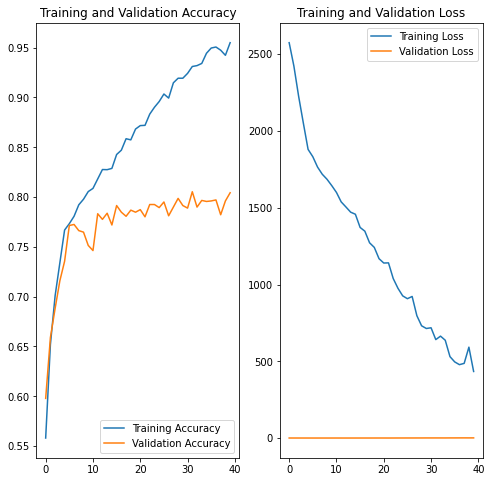

In [43]:
#Graph Accuracy and Loss
acc = fit_result.history['accuracy']
val_acc = fit_result.history['val_accuracy']

loss = fit_result.history['loss']
val_loss = fit_result.history['val_loss']

epochs_range = range(epochs_m)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


Confusion Matrix
Classification Report
              precision    recall  f1-score   support

           0       0.80      0.80      0.80       900
           1       0.83      0.82      0.83      1047

    accuracy                           0.81      1947
   macro avg       0.81      0.81      0.81      1947
weighted avg       0.81      0.81      0.81      1947

Print stats
Sensitivity 0.82
Specificity 0.80
Overall accuracy 0.81


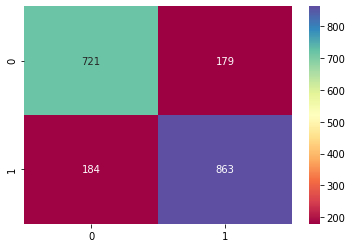

In [53]:
#Confution Matrix and Classification Report

#Validation
Y_pred_m = model_m.predict_generator(validate_img_generator_m, validate_total_m // batch_size_m+1)
y_pred_m = np.where(Y_pred_m>0.5, 1, 0)
print('Confusion Matrix')
cm_m = metrics.confusion_matrix(validate_img_generator_m.classes, y_pred_m)
# print(cm_m)

#Picture
sns.heatmap(cm_m, annot=True, fmt = "d", cmap="Spectral")
results_path = './CM_Manchester.png'
plt.savefig(results_path)

print('Classification Report')
print(metrics.classification_report(validate_img_generator_m.classes, y_pred_m))

print('Print stats')

TN = cm_m[0][0]
FN = cm_m[1][0]
TP = cm_m[1][1]
FP = cm_m[0][1]


# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)

print('Sensitivity', "%.2f"%TPR)
print('Specificity',"%.2f"%TNR)
print('Overall accuracy', "%.2f"%ACC)


### Other models on Leeds and Manchester data

In [10]:
#Try with regularization
model_tm = Sequential()
model_tm.add(Conv2D(32, (3, 3), input_shape=(img_height_m, img_width_m, 3)))
model_tm.add(Activation('relu'))
model_tm.add(MaxPooling2D(pool_size=(2, 2)))
model_tm.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(l=0.01)))
model_tm.add(MaxPooling2D(pool_size=(2, 2)))
model_tm.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(l=0.01)))
model_tm.add(MaxPooling2D(pool_size=(2, 2)))
model_tm.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_tm.add(Activation('relu'))
model_tm.add(MaxPooling2D(pool_size=(2, 2)))
model_tm.add(Flatten())
model_tm.add(Dense(256, activation='relu'))
model_tm.add(Dropout(0.5))
model_tm.add(Dense(1, activation='sigmoid'))



#Compile the Model
model_tm.compile(loss = 'binary_crossentropy',
 optimizer = 'adam',
 metrics = ['accuracy'])



#Run model
epochs_tm = 40
fit_result = model_tm.fit_generator(train_img_generator_m,
 steps_per_epoch=int(np.ceil(train_total_m / float(batch_size_m))),
 epochs=epochs_tm,
 validation_data=validate_img_generator_m,
 validation_steps=int(np.ceil(validate_total_m / float(batch_size_m))),
 class_weight=dict(enumerate([num_cy_train_m,num_ncy_train_m])) 
 )


Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/40
245/245 [==============================] - 136s 557ms/step - loss: 2546.0181 - accuracy: 0.5761 - val_loss: 1.8567 - val_accuracy: 0.6122
Epoch 2/40
245/245 [==============================] - 93s 381ms/step - loss: 2299.3496 - accuracy: 0.6855 - val_loss: 1.9086 - val_accuracy: 0.6903
Epoch 3/40
245/245 [==============================] - 92s 376ms/step - loss: 1979.1895 - accuracy: 0.7500 - val_loss: 1.9419 - val_accuracy: 0.7648
Epoch 4/40
245/245 [==============================] - 95s 386ms/step - loss: 1862.0210 - accuracy: 0.7682 - val_loss: 2.1135 - val_accuracy: 0.7201
Epoch 5/40
245/245 [==============================] - 96s 393ms/step - loss: 1805.1890 - accuracy: 0.7817 - val_loss: 2.1339 - val_accuracy: 0.7678
Epoch 6/40
245/245 [==============================] - 98s 399ms/step - loss: 1745.1477 - accuracy: 0.7864 - val_loss: 2.2319 - val_accuracy: 0.7509
Epoch 7/40
245/245 [===============

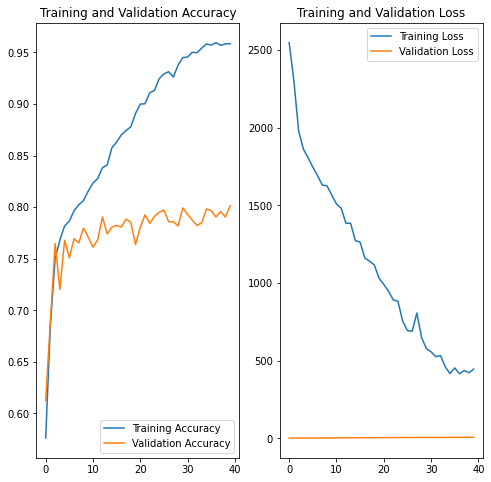

In [12]:
#Graph Accuracy and Loss
acc = fit_result.history['accuracy']
val_acc = fit_result.history['val_accuracy']

loss = fit_result.history['loss']
val_loss = fit_result.history['val_loss']

epochs_range = range(epochs_tm)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Confusion Matrix
Classification Report
              precision    recall  f1-score   support

           0       0.77      0.82      0.79       900
           1       0.83      0.79      0.81      1047

    accuracy                           0.80      1947
   macro avg       0.80      0.80      0.80      1947
weighted avg       0.80      0.80      0.80      1947

Print stats
Sensitivity 0.79
Specificity 0.82
Overall accuracy 0.80


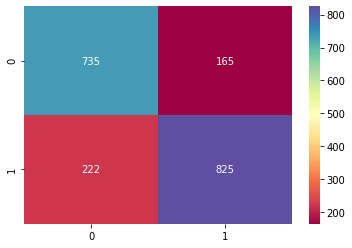

In [14]:
#Confution Matrix and Classification Report

#Validation
Y_pred_tm = model_tm.predict_generator(validate_img_generator_m, validate_total_m // batch_size_m+1)
y_pred_tm = np.where(Y_pred_tm>0.5, 1, 0)
print('Confusion Matrix')
cm_tm = metrics.confusion_matrix(validate_img_generator_m.classes, y_pred_tm)
# print(cm_m)

#Picture
sns.heatmap(cm_tm, annot=True, fmt = "d", cmap="Spectral")
results_path = './CM_Reg.png'
plt.savefig(results_path)

print('Classification Report')
print(metrics.classification_report(validate_img_generator_m.classes, y_pred_tm))

print('Print stats')

TN = cm_tm[0][0]
FN = cm_tm[1][0]
TP = cm_tm[1][1]
FP = cm_tm[0][1]


# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)

print('Sensitivity', "%.2f"%TPR)
print('Specificity',"%.2f"%TNR)
print('Overall accuracy', "%.2f"%ACC)

## Increase train sample by augmentation

In [20]:
#Increase train sample
#cy

img_path = './Output Image/grid/train man/cy'
outpath = './Output Image/grid/train aug/'

filenames = glob.glob(img_path + "/**/*.png",recursive=True)


for img in filenames:

    if "DS_Store" in img: continue
    src_fname, ext = os.path.splitext(img) 

    datagen = ImageDataGenerator(rotation_range = 25,
            width_shift_range=0.10,
            height_shift_range=0.10,
            fill_mode='constant',cval=0.0,
            brightness_range = (0.5, 1.5),
            shear_range = 0.2,
            zoom_range = 0.2)


    img = load_img(img)

    x = img_to_array(img)
    x = x.reshape((1,) + x.shape)

    img_name = src_fname.split('/')[-1]
    save_fname = outpath
    i = 0
    for batch in datagen.flow (x, batch_size=1, save_to_dir = save_fname, 
                               save_prefix = img_name, save_format='png'):
        i+=1
        if i>4:
            break

In [21]:
#Increase train sample
#ncy

img_path = './Output Image/grid/train man/ncy'
outpath = './Output Image/grid/train aug/'

filenames = glob.glob(img_path + "/**/*.png",recursive=True)


for img in filenames:

    if "DS_Store" in img: continue
    src_fname, ext = os.path.splitext(img) 

    datagen = ImageDataGenerator(rotation_range = 25,
            width_shift_range=0.10,
            height_shift_range=0.10,
            fill_mode='constant',cval=0.0,
            brightness_range = (0.5, 1.5),
            shear_range = 0.2,
            zoom_range = 0.2)


    img = load_img(img)

    x = img_to_array(img)
    x = x.reshape((1,) + x.shape)

    img_name = src_fname.split('/')[-1]
    save_fname = outpath
    i = 0
    for batch in datagen.flow (x, batch_size=1, save_to_dir = save_fname, 
                               save_prefix = img_name, save_format='png'):
        i+=1
        if i>4:
            break

## Model with augmented data

In [56]:
#Set locations of data
train_dir_a = './Output Image/grid/train aug/'
validate_dir_a = './Output Image/grid/validation man/'

#Train
train_ncy_dir_a = os.path.join(train_dir_a, 'ncy')
train_cy_dir_a = os.path.join(train_dir_a, 'cy')

#Validation
validate_ncy_dir_a = os.path.join(validate_dir_a, 'ncy')
validate_cy_dir_a = os.path.join(validate_dir_a, 'cy')

num_ncy_train_a = len(os.listdir(train_ncy_dir_a))
num_cy_train_a = len(os.listdir(train_cy_dir_a))

num_ncy_validate_a = len(os.listdir(validate_ncy_dir_a))
num_cy_validate_a = len(os.listdir(validate_cy_dir_a))

train_total_a = num_ncy_train_a + num_cy_train_a
validate_total_a = num_ncy_validate_a + num_cy_validate_a

#Print numbers
print(train_total_a)
print(validate_total_a)

39093
1947


In [57]:
#Model parameters
batch_size_a = 32
img_height_a = 100
img_width_a = 100

img_generator = ImageDataGenerator(rescale=1./255)

In [59]:
#Get images for model
train_img_generator_a =img_generator.flow_from_directory(color_mode ='rgb', batch_size=batch_size_a,directory=train_dir_a,shuffle=True,target_size=(img_height_a,img_width_a),class_mode='binary',seed=42)

validate_img_generator_a =img_generator.flow_from_directory(color_mode ='rgb',batch_size=batch_size_a,directory=validate_dir_a,shuffle=False,
 target_size=(img_height_a,img_width_a),
 class_mode='binary',seed=42)

Found 39093 images belonging to 2 classes.
Found 1947 images belonging to 2 classes.


In [60]:
#model components
model_a = Sequential()
model_a.add(Conv2D(32, (3, 3), input_shape=(img_height_a, img_width_a, 3)))
model_a.add(Activation('relu'))
model_a.add(MaxPooling2D(pool_size=(2, 2)))
model_a.add(Conv2D(64, (3, 3)))
model_a.add(Activation('relu'))
model_a.add(MaxPooling2D(pool_size=(2, 2)))
model_a.add(Conv2D(128, (3, 3)))
model_a.add(Activation('relu'))
model_a.add(MaxPooling2D(pool_size=(2, 2)))
model_a.add(Conv2D(128, (3, 3)))
model_a.add(Activation('relu'))
model_a.add(MaxPooling2D(pool_size=(2, 2)))
model_a.add(Flatten())
model_a.add(Dense(256, activation='relu'))
model_a.add(Dropout(0.5))
model_a.add(Dense(1, activation='sigmoid'))

In [64]:
#Compile the Model
model_a.compile(loss = 'binary_crossentropy',
 optimizer = 'adam',
 metrics = ['accuracy'])

In [65]:
#Run model
epochs_a = 40
fit_result_a = model_a.fit_generator(train_img_generator_a,
 steps_per_epoch=int(np.ceil(train_total_a / float(batch_size_a))),
 epochs=epochs_a,
 validation_data=validate_img_generator_a,
 validation_steps=int(np.ceil(validate_total_a / float(batch_size_a))),
 class_weight=dict(enumerate([num_cy_train_a,num_ncy_train_a])) 
 )

Epoch 1/40
1222/1222 [==============================] - 725s 594ms/step - loss: 11895.7695 - accuracy: 0.6481 - val_loss: 0.6635 - val_accuracy: 0.6153
Epoch 2/40
1222/1222 [==============================] - 425s 348ms/step - loss: 10831.1719 - accuracy: 0.7100 - val_loss: 0.6472 - val_accuracy: 0.6107
Epoch 3/40
1222/1222 [==============================] - 415s 339ms/step - loss: 10464.7402 - accuracy: 0.7254 - val_loss: 0.7298 - val_accuracy: 0.6133
Epoch 4/40
1222/1222 [==============================] - 410s 336ms/step - loss: 10166.6191 - accuracy: 0.7335 - val_loss: 0.8317 - val_accuracy: 0.5860
Epoch 5/40
1222/1222 [==============================] - 410s 336ms/step - loss: 9850.0684 - accuracy: 0.7436 - val_loss: 0.7652 - val_accuracy: 0.5845
Epoch 6/40
1222/1222 [==============================] - 412s 338ms/step - loss: 9527.6895 - accuracy: 0.7561 - val_loss: 0.7058 - val_accuracy: 0.6133
Epoch 7/40
1222/1222 [==============================] - 411s 336ms/step - loss: 9144.2568 

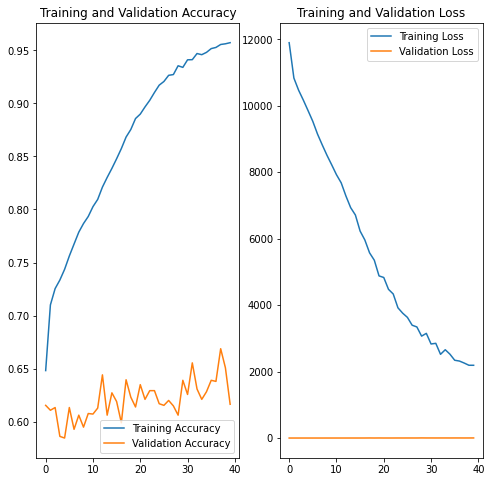

In [66]:
#Graph Accuracy and Loss
acc = fit_result_a.history['accuracy']
val_acc = fit_result_a.history['val_accuracy']

loss = fit_result_a.history['loss']
val_loss = fit_result_a.history['val_loss']

epochs_range = range(epochs_a)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Confusion Matrix
Classification Report
              precision    recall  f1-score   support

           0       0.72      0.28      0.40       900
           1       0.59      0.91      0.72      1047

    accuracy                           0.62      1947
   macro avg       0.66      0.59      0.56      1947
weighted avg       0.65      0.62      0.57      1947

Print stats
Sensitivity 0.91
Specificity 0.28
Overall accuracy 0.62


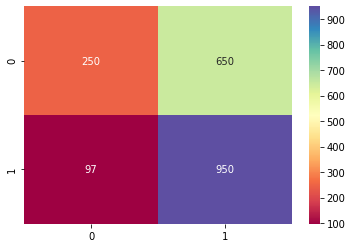

In [67]:
#Confution Matrix and Classification Report
#https://gist.github.com/RyanAkilos/3808c17f79e77c4117de35aa68447045

#Validation
Y_pred_a = model_a.predict_generator(validate_img_generator_a, validate_total_a // batch_size_a+1)
y_pred_a = np.where(Y_pred_a>0.5, 1, 0)
print('Confusion Matrix')
cm_a = metrics.confusion_matrix(validate_img_generator_a.classes, y_pred_a)
# print(cm_m)

#Picture
sns.heatmap(cm_a, annot=True, fmt = "d", cmap="Spectral")
results_path = './CM_Aug.png'
plt.savefig(results_path)

print('Classification Report')
print(metrics.classification_report(validate_img_generator_a.classes, y_pred_a))

print('Print stats')

TN = cm_a[0][0]
FN = cm_a[1][0]
TP = cm_a[1][1]
FP = cm_a[0][1]


# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)

print('Sensitivity', "%.2f"%TPR)
print('Specificity',"%.2f"%TNR)
print('Overall accuracy', "%.2f"%ACC)

## Extra testing on Leeds and Manchester Model

Found 700 images belonging to 2 classes.
Confusion Matrix
Classification Report
              precision    recall  f1-score   support

           0       0.67      0.41      0.51       350
           1       0.57      0.80      0.67       350

    accuracy                           0.60       700
   macro avg       0.62      0.60      0.59       700
weighted avg       0.62      0.60      0.59       700

Print stats
Sensitivity 0.80
Specificity 0.41
Overall accuracy 0.60


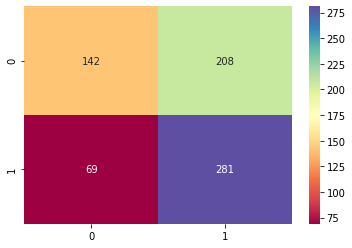

In [92]:
#Take 350 from augmented data set each for canyon and non canyon

validate_dir_et = './Output Image/grid/test/'

#Validation
validate_ncy_dir_et = os.path.join(validate_dir_et, 'ncy')
validate_cy_dir_et = os.path.join(validate_dir_et, 'cy')

num_ncy_validate_et = len(os.listdir(validate_ncy_dir_et))
num_cy_validate_et = len(os.listdir(validate_cy_dir_et))

validate_total_et = num_ncy_validate_et + num_cy_validate_et

validate_img_generator_et =img_generator.flow_from_directory(color_mode ='rgb',batch_size=batch_size_m,directory=validate_dir_et,shuffle=False,
 target_size=(img_height_m,img_width_m),
 class_mode='binary',seed=42)



#Validation
Y_pred_et = model_m.predict_generator(validate_img_generator_et, validate_total_et // batch_size_m+1)
y_pred_et = np.where(Y_pred_et>0.5, 1, 0)
print('Confusion Matrix')
cm_et = metrics.confusion_matrix(validate_img_generator_et.classes, y_pred_et)
# print(cm_m)

#Picture
sns.heatmap(cm_et, annot=True, fmt = "d", cmap="Spectral")
results_path = './CM_testing.png'
plt.savefig(results_path)

print('Classification Report')
print(metrics.classification_report(validate_img_generator_et.classes, y_pred_et))

print('Print stats')

TN = cm_et[0][0]
FN = cm_et[1][0]
TP = cm_et[1][1]
FP = cm_et[0][1]


# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)

print('Sensitivity', "%.2f"%TPR)
print('Specificity',"%.2f"%TNR)
print('Overall accuracy', "%.2f"%ACC)





## Model Canyon types 

In [80]:
#Set locations of data
train_dir_tna = './Output Image/grid/train canyons/'
validate_dir_tna = './Output Image/grid/validation canyons/'


#Train
train_H_dir = os.path.join(train_dir_tna, 'H')
train_HH_dir = os.path.join(train_dir_tna, 'HH')
train_L_dir = os.path.join(train_dir_tna, 'L')
train_LL_dir = os.path.join(train_dir_tna, 'LL')

#Validation
validate_H_dir = os.path.join(validate_dir_tna, 'H')
validate_HH_dir = os.path.join(validate_dir_tna, 'HH')
validate_L_dir = os.path.join(validate_dir_tna, 'L')
validate_LL_dir = os.path.join(validate_dir_tna, 'LL')


num_HH_train = len(os.listdir(train_HH_dir))
num_H_train = len(os.listdir(train_H_dir))
num_L_train = len(os.listdir(train_L_dir))
num_LL_train = len(os.listdir(train_LL_dir))

num_HH_validate = len(os.listdir(validate_HH_dir))
num_H_validate = len(os.listdir(validate_H_dir))
num_LL_validate = len(os.listdir(validate_LL_dir))
num_L_validate = len(os.listdir(validate_L_dir))

train_total_tna = num_HH_train + num_H_train + num_L_train + num_LL_train
validate_total_tna = num_HH_validate + num_H_validate + num_LL_validate + num_L_validate


#Number of images
print(train_total_tna)
print(validate_total_tna)

#Model parameters
batch_size_tna = 32
img_height_tna = 100
img_width_tna = 100

3606
900


In [81]:
#Model parameters
img_generator = ImageDataGenerator(rescale=1./255)



#Get images for model
train_img_generator_tna =img_generator.flow_from_directory(color_mode ='rgb', batch_size=batch_size_tna,directory=train_dir_tna,shuffle=True,target_size=(img_height_tna, img_width_tna),
                                                       class_mode='categorical' #Changed to categorical
                                                      ,seed =5)

validate_img_generator_tna =img_generator.flow_from_directory(color_mode ='rgb', batch_size=batch_size_tna,directory=validate_dir_tna,shuffle=False,
 target_size=(img_height_tna, img_width_tna),
 class_mode='categorical',seed =5)  #Changed to categorical

Found 3606 images belonging to 4 classes.
Found 900 images belonging to 4 classes.


In [82]:
#model components
model_tna = Sequential()
model_tna.add(Conv2D(32, (3, 3), input_shape=(img_height_tna, img_width_tna,3)))
model_tna.add(Activation('relu'))
model_tna.add(MaxPooling2D(pool_size=(2, 2)))
model_tna.add(Conv2D(64, (3, 3)))
model_tna.add(Activation('relu'))
model_tna.add(MaxPooling2D(pool_size=(2, 2)))
model_tna.add(Conv2D(128, (3, 3)))
model_tna.add(Activation('relu'))
model_tna.add(MaxPooling2D(pool_size=(2, 2)))
model_tna.add(Conv2D(128, (3, 3)))
model_tna.add(Activation('relu'))
model_tna.add(MaxPooling2D(pool_size=(2, 2)))
model_tna.add(Flatten())
model_tna.add(Dense(256, activation='relu'))
model_tna.add(Dropout(0.5))
#model.add(Dense(1, activation='sigmoid')) 
model_tna.add(Dense(4, activation='softmax')) # Updated from 1 to 3 as three classes and changed to softmax

#Compile the Model
model_tna.compile(loss = 'categorical_crossentropy', #change from binary
 optimizer = 'rmsprop',
 metrics = ['accuracy'])

In [83]:
#Run model
epochs_tna = 40
fit_result_tna = model_tna.fit_generator(train_img_generator_tna,
 steps_per_epoch=int(np.ceil(train_total_tna / float(batch_size_tna))),
 epochs=epochs_tna,
 validation_data=validate_img_generator_tna,
 validation_steps=int(np.ceil(validate_total_tna / float(batch_size_tna))),
 class_weight=dict(enumerate([num_H_train,num_HH_train,num_L_train,num_LL_train]))
 )

Epoch 1/40
113/113 [==============================] - 71s 625ms/step - loss: 1214.1603 - accuracy: 0.3652 - val_loss: 1.3148 - val_accuracy: 0.3644
Epoch 2/40
113/113 [==============================] - 68s 605ms/step - loss: 1168.1012 - accuracy: 0.4165 - val_loss: 1.3264 - val_accuracy: 0.4122
Epoch 3/40
113/113 [==============================] - 70s 619ms/step - loss: 1120.5608 - accuracy: 0.4401 - val_loss: 1.2598 - val_accuracy: 0.4456
Epoch 4/40
113/113 [==============================] - 68s 606ms/step - loss: 1085.4961 - accuracy: 0.4576 - val_loss: 1.3072 - val_accuracy: 0.4278
Epoch 5/40
113/113 [==============================] - 69s 614ms/step - loss: 1053.5842 - accuracy: 0.4773 - val_loss: 1.2425 - val_accuracy: 0.4533
Epoch 6/40
113/113 [==============================] - 69s 613ms/step - loss: 1015.9899 - accuracy: 0.4886 - val_loss: 1.2679 - val_accuracy: 0.4544
Epoch 7/40
113/113 [==============================] - 69s 611ms/step - loss: 993.7526 - accuracy: 0.5042 - val_l

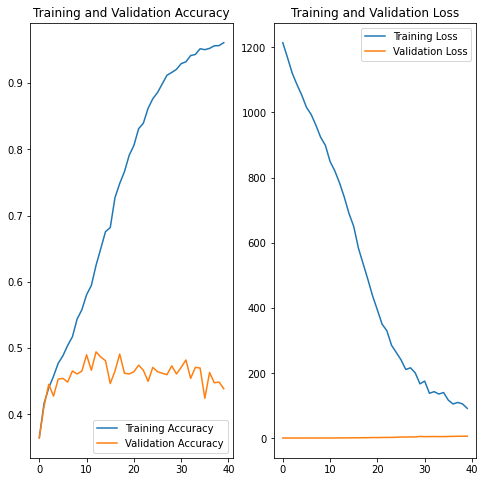

In [84]:
 #Graph Accuracy and Loss
acc = fit_result_tna.history['accuracy']
val_acc = fit_result_tna.history['val_accuracy']

loss = fit_result_tna.history['loss']
val_loss = fit_result_tna.history['val_loss']

epochs_range = range(epochs_tna)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Confusion Matrix
[[ 41  38  44   9]
 [ 32 149  95  12]
 [ 55  94 161  18]
 [ 18  47  43  44]]
Classification Report Canyon Type
              precision    recall  f1-score   support

           0       0.28      0.31      0.29       132
           1       0.45      0.52      0.48       288
           2       0.47      0.49      0.48       328
           3       0.53      0.29      0.37       152

    accuracy                           0.44       900
   macro avg       0.43      0.40      0.41       900
weighted avg       0.45      0.44      0.44       900



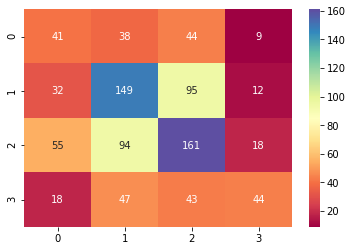

In [85]:
#Confution Matrix and Classification Report

Y_pred_tna = model_tna.predict_generator(validate_img_generator_tna, validate_total_tna // batch_size_tna+1)
y_pred_tna = np.argmax(Y_pred_tna, axis=1)

print('Confusion Matrix')
print(confusion_matrix(validate_img_generator_tna.classes, y_pred_tna))
cm_tna=confusion_matrix(validate_img_generator_tna.classes, y_pred_tna)
#Picture
sns.heatmap(cm_tna, annot=True, fmt = "d", cmap="Spectral")
results_path = './CM_Canyon_Type_na.png'
plt.savefig(results_path)

print('Classification Report Canyon Type')
target_names = ['H', 'HH','L', 'LL']
print(classification_report(validate_img_generator_tna.classes, y_pred_tna))


In [ ]:
#Create more data
#Alter image to create more

In [22]:
#H
#Train
img_path = './Output Image/grid/train canyons/H'
outpath = './Output Image/grid/train canyons aug/'

filenames = glob.glob(img_path + "/**/*.png",recursive=True)


for img in filenames:

    if "DS_Store" in img: continue
    src_fname, ext = os.path.splitext(img) 

    datagen = ImageDataGenerator(rotation_range = 25,
            width_shift_range=0.10,
            height_shift_range=0.10,
            fill_mode='constant',cval=0.0,
            brightness_range = (0.5, 1.5),
            shear_range = 0.2,
            zoom_range = 0.2)


    img = load_img(img)

    x = img_to_array(img)
    x = x.reshape((1,) + x.shape)

    img_name = src_fname.split('/')[-1]
    save_fname = outpath
    i = 0
    for batch in datagen.flow (x, batch_size=1, save_to_dir = save_fname, 
                               save_prefix = img_name, save_format='png'):
        i+=1
        if i>8:
            break



In [23]:
#H
#Validation

img_path = './Output Image/grid/validation canyons/H'
outpath = './Output Image/grid/validation canyons aug/'

filenames = glob.glob(img_path + "/**/*.png",recursive=True)


for img in filenames:

    if "DS_Store" in img: continue
    src_fname, ext = os.path.splitext(img) 

    datagen = ImageDataGenerator(rotation_range = 25,
            width_shift_range=0.10,
            height_shift_range=0.10,
            fill_mode='constant',cval=0.0,
            brightness_range = (0.5, 1.5),
            shear_range = 0.2,
            zoom_range = 0.2)


    img = load_img(img)

    x = img_to_array(img)
    x = x.reshape((1,) + x.shape)

    img_name = src_fname.split('/')[-1]
    save_fname = outpath
    i = 0
    for batch in datagen.flow (x, batch_size=1, save_to_dir = save_fname, 
                               save_prefix = img_name, save_format='png'):
        i+=1
        if i>8:
            break


In [24]:
#HH
#train

img_path = './Output Image/grid/train canyons/HH'
outpath = './Output Image/grid/train canyons aug/'

filenames = glob.glob(img_path + "/**/*.png",recursive=True)


for img in filenames:

    if "DS_Store" in img: continue
    src_fname, ext = os.path.splitext(img) 

    datagen = ImageDataGenerator(rotation_range = 25,
            width_shift_range=0.10,
            height_shift_range=0.10,
            fill_mode='constant',cval=0.0,
            brightness_range = (0.5, 1.5),
            shear_range = 0.2,
            zoom_range = 0.2)


    img = load_img(img)

    x = img_to_array(img)
    x = x.reshape((1,) + x.shape)

    img_name = src_fname.split('/')[-1]
    save_fname = outpath
    i = 0
    for batch in datagen.flow (x, batch_size=1, save_to_dir = save_fname, 
                               save_prefix = img_name, save_format='png'):
        i+=1
        if i>8:
            break



In [25]:
#HH
img_path = './Output Image/grid/validation canyons/HH'
outpath = './Output Image/grid/validation canyons aug/'

filenames = glob.glob(img_path + "/**/*.png",recursive=True)


for img in filenames:

    if "DS_Store" in img: continue
    src_fname, ext = os.path.splitext(img) 

    datagen = ImageDataGenerator(rotation_range = 25,
            width_shift_range=0.10,
            height_shift_range=0.10,
            fill_mode='constant',cval=0.0,
            brightness_range = (0.5, 1.5),
            shear_range = 0.2,
            zoom_range = 0.2)


    img = load_img(img)

    x = img_to_array(img)
    x = x.reshape((1,) + x.shape)

    img_name = src_fname.split('/')[-1]
    save_fname = outpath
    i = 0
    for batch in datagen.flow (x, batch_size=1, save_to_dir = save_fname, 
                               save_prefix = img_name, save_format='png'):
        i+=1
        if i>8:
            break


In [26]:
#L

img_path = './Output Image/grid/train canyons/L'
outpath = './Output Image/grid/train canyons aug/'

filenames = glob.glob(img_path + "/**/*.png",recursive=True)


for img in filenames:

    if "DS_Store" in img: continue
    src_fname, ext = os.path.splitext(img) 

    datagen = ImageDataGenerator(rotation_range = 25,
            width_shift_range=0.10,
            height_shift_range=0.10,
            fill_mode='constant',cval=0.0,
            brightness_range = (0.5, 1.5),
            shear_range = 0.2,
            zoom_range = 0.2)


    img = load_img(img)

    x = img_to_array(img)
    x = x.reshape((1,) + x.shape)

    img_name = src_fname.split('/')[-1]
    save_fname = outpath
    i = 0
    for batch in datagen.flow (x, batch_size=1, save_to_dir = save_fname, 
                               save_prefix = img_name, save_format='png'):
        i+=1
        if i>8:
            break



In [27]:
#L
#Validation

img_path = './Output Image/grid/validation canyons aug/L'
outpath = './Output Image/grid/validation canyons aug/'

filenames = glob.glob(img_path + "/**/*.png",recursive=True)


for img in filenames:

    if "DS_Store" in img: continue
    src_fname, ext = os.path.splitext(img) 

    datagen = ImageDataGenerator(rotation_range = 25,
            width_shift_range=0.10,
            height_shift_range=0.10,
            fill_mode='constant',cval=0.0,
            brightness_range = (0.5, 1.5),
            shear_range = 0.2,
            zoom_range = 0.2)


    img = load_img(img)

    x = img_to_array(img)
    x = x.reshape((1,) + x.shape)

    img_name = src_fname.split('/')[-1]
    save_fname = outpath
    i = 0
    for batch in datagen.flow (x, batch_size=1, save_to_dir = save_fname, 
                               save_prefix = img_name, save_format='png'):
        i+=1
        if i>8:
            break

In [28]:
#LL

img_path = './Output Image/grid/train canyons/LL'
outpath = './Output Image/grid/train canyons aug/'

filenames = glob.glob(img_path + "/**/*.png",recursive=True)


for img in filenames:

    if "DS_Store" in img: continue
    src_fname, ext = os.path.splitext(img) 

    datagen = ImageDataGenerator(rotation_range = 25,
            width_shift_range=0.10,
            height_shift_range=0.10,
            fill_mode='constant',cval=0.0,
            brightness_range = (0.5, 1.5),
            shear_range = 0.2,
            zoom_range = 0.2)


    img = load_img(img)

    x = img_to_array(img)
    x = x.reshape((1,) + x.shape)

    img_name = src_fname.split('/')[-1]
    save_fname = outpath
    i = 0
    for batch in datagen.flow (x, batch_size=1, save_to_dir = save_fname, 
                               save_prefix = img_name, save_format='png'):
        i+=1
        if i>8:
            break




In [29]:
#LL

img_path = './Output Image/grid/validation canyons aug/LL'
outpath = './Output Image/grid/validation canyons aug/'

filenames = glob.glob(img_path + "/**/*.png",recursive=True)


for img in filenames:

    if "DS_Store" in img: continue
    src_fname, ext = os.path.splitext(img) 

    datagen = ImageDataGenerator(rotation_range = 25,
            width_shift_range=0.10,
            height_shift_range=0.10,
            fill_mode='constant',cval=0.0,
            brightness_range = (0.5, 1.5),
            shear_range = 0.2,
            zoom_range = 0.2)


    img = load_img(img)

    x = img_to_array(img)
    x = x.reshape((1,) + x.shape)

    img_name = src_fname.split('/')[-1]
    save_fname = outpath
    i = 0
    for batch in datagen.flow (x, batch_size=1, save_to_dir = save_fname, 
                               save_prefix = img_name, save_format='png'):
        i+=1
        if i>8:
            break




In [86]:
#Set locations of data
train_dir_t = './Output Image/grid/train canyons aug/'
validate_dir_t = './Output Image/grid/validation canyons aug/'


#Train
train_H_dir = os.path.join(train_dir_t, 'H')
train_HH_dir = os.path.join(train_dir_t, 'HH')
train_L_dir = os.path.join(train_dir_t, 'L')
train_LL_dir = os.path.join(train_dir_t, 'LL')

#Validation
validate_H_dir = os.path.join(validate_dir_t, 'H')
validate_HH_dir = os.path.join(validate_dir_t, 'HH')
validate_L_dir = os.path.join(validate_dir_t, 'L')
validate_LL_dir = os.path.join(validate_dir_t, 'LL')


num_HH_train = len(os.listdir(train_HH_dir))
num_H_train = len(os.listdir(train_H_dir))
num_L_train = len(os.listdir(train_L_dir))
num_LL_train = len(os.listdir(train_LL_dir))

num_HH_validate = len(os.listdir(validate_HH_dir))
num_H_validate = len(os.listdir(validate_H_dir))
num_LL_validate = len(os.listdir(validate_LL_dir))
num_L_validate = len(os.listdir(validate_L_dir))

train_total_t = num_HH_train + num_H_train + num_L_train + num_LL_train
validate_total_t = num_HH_validate + num_H_validate + num_LL_validate + num_L_validate


#Number of images
print(train_total_t)
print(validate_total_t)

#Model parameters
batch_size_t = 32
img_height_t = 100
img_width_t = 100


32435
3778


In [87]:

#Model parameters
img_generator = ImageDataGenerator(rescale=1./255)


#Get images for model
train_img_generator_t =img_generator.flow_from_directory(color_mode ='rgb', batch_size=batch_size_t,directory=train_dir_t,shuffle=True,target_size=(img_height_t, img_width_t),
                                                       class_mode='categorical' #Changed to categorical
                                                      ,seed =5)

validate_img_generator_t =img_generator.flow_from_directory(color_mode ='rgb', batch_size=batch_size_t,directory=validate_dir_t,shuffle=False,
 target_size=(img_height_t, img_width_t),
 class_mode='categorical',seed =5)  #Changed to categorical


Found 32435 images belonging to 4 classes.
Found 3778 images belonging to 4 classes.


In [76]:
#model components
model_t = Sequential()
model_t.add(Conv2D(32, (3, 3), input_shape=(img_height_t, img_width_t,3)))
model_t.add(Activation('relu'))
model_t.add(MaxPooling2D(pool_size=(2, 2)))
model_t.add(Conv2D(64, (3, 3)))
model_t.add(Activation('relu'))
model_t.add(MaxPooling2D(pool_size=(2, 2)))
model_t.add(Conv2D(128, (3, 3)))
model_t.add(Activation('relu'))
model_t.add(MaxPooling2D(pool_size=(2, 2)))
model_t.add(Conv2D(128, (3, 3)))
model_t.add(Activation('relu'))
model_t.add(MaxPooling2D(pool_size=(2, 2)))
model_t.add(Flatten())
model_t.add(Dense(256, activation='relu'))
model_t.add(Dropout(0.5))
#model.add(Dense(1, activation='sigmoid')) 
model_t.add(Dense(4, activation='softmax')) # Updated from 1 to 3 as three classes and changed to softmax

#Compile the Model
model_t.compile(loss = 'categorical_crossentropy', #change from binary
 optimizer = 'rmsprop',
 metrics = ['accuracy'])



In [88]:
#Run model
epochs_t = 40
fit_result_t = model_t.fit_generator(train_img_generator_t,
 steps_per_epoch=int(np.ceil(train_total_t / float(batch_size_t))),
 epochs=epochs_t,
 validation_data=validate_img_generator_t,
 validation_steps=int(np.ceil(validate_total_t / float(batch_size_t))),
 class_weight=dict(enumerate([num_H_train,num_HH_train,num_L_train,num_LL_train]))
 )



Epoch 1/40
1014/1014 [==============================] - 426s 420ms/step - loss: 10976.9209 - accuracy: 0.3571 - val_loss: 1.4824 - val_accuracy: 0.0267
Epoch 2/40
1014/1014 [==============================] - 369s 364ms/step - loss: 10262.8379 - accuracy: 0.4236 - val_loss: 1.5593 - val_accuracy: 0.3158
Epoch 3/40
1014/1014 [==============================] - 364s 359ms/step - loss: 9461.1602 - accuracy: 0.4823 - val_loss: 1.5078 - val_accuracy: 0.3190
Epoch 4/40
1014/1014 [==============================] - 363s 358ms/step - loss: 9084.2139 - accuracy: 0.5034 - val_loss: 1.4155 - val_accuracy: 0.3888
Epoch 5/40
1014/1014 [==============================] - 366s 361ms/step - loss: 8835.6953 - accuracy: 0.5169 - val_loss: 1.5926 - val_accuracy: 0.2771
Epoch 6/40
1014/1014 [==============================] - 501s 494ms/step - loss: 8636.8213 - accuracy: 0.5316 - val_loss: 1.5203 - val_accuracy: 0.3401
Epoch 7/40
1014/1014 [==============================] - 614s 605ms/step - loss: 8475.3906 - 

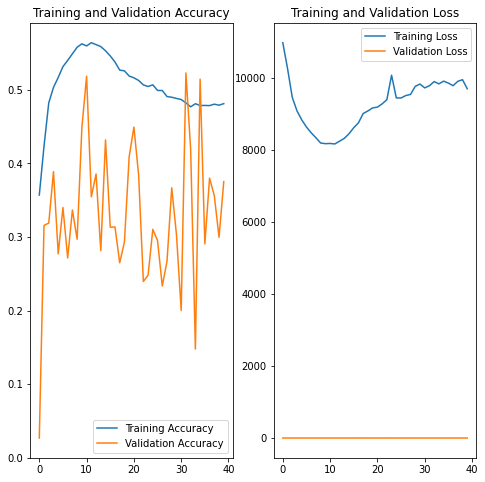

In [89]:
 #Graph Accuracy and Loss
acc = fit_result_t.history['accuracy']
val_acc = fit_result_t.history['val_accuracy']

loss = fit_result_t.history['loss']
val_loss = fit_result_t.history['val_loss']

epochs_range = range(epochs_t)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Confusion Matrix
[[  11  310  865    2]
 [   8 1407 1175    0]
 [   0    0    0    0]
 [   0    0    0    0]]
Classification Report Canyon Type
              precision    recall  f1-score   support

           0       0.58      0.01      0.02      1188
           1       0.82      0.54      0.65      2590
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0

    accuracy                           0.38      3778
   macro avg       0.35      0.14      0.17      3778
weighted avg       0.74      0.38      0.45      3778



c:\users\rachel\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\rachel\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\rachel\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

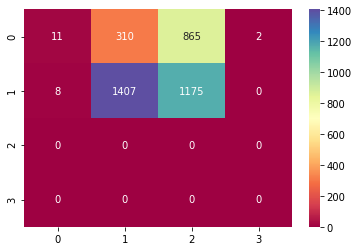

In [90]:
#Confution Matrix and Classification Report

Y_pred_t = model_t.predict_generator(validate_img_generator_t, validate_total_t // batch_size_t+1)
y_pred_t = np.argmax(Y_pred_t, axis=1)

print('Confusion Matrix')
print(confusion_matrix(validate_img_generator_t.classes, y_pred_t))
cm_t=confusion_matrix(validate_img_generator_t.classes, y_pred_t)
#Picture
sns.heatmap(cm_t, annot=True, fmt = "d", cmap="Spectral")
results_path = './CM_Canyon_Type.png'
plt.savefig(results_path)

print('Classification Report Canyon Type')
target_names = ['H', 'HH','L', 'LL']
print(classification_report(validate_img_generator_t.classes, y_pred_t))

## Clustering  Solar and surface temperature data Leeds HH Canyons

In [48]:
#Solar data HH

Leeds_HH_S = pd.read_excel('./data/Leeds_hh_Solar.xlsx'
              )
summary_d(Leeds_HH_S)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12152 entries, 0 to 12151
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   fid      12152 non-null  int64  
 1   x        12152 non-null  float64
 2   y        12152 non-null  float64
 3   Solar_1  12152 non-null  float64
dtypes: float64(3), int64(1)
memory usage: 379.9 KB


,fid,Solar_1
0,37,5337.399902
1,37,5457.796875
2,37,1007.169006
3,37,648.586426
4,37,266.552490
...,...,...
12147,10394,1103.968994
12148,10394,1103.968994
12149,10394,1897.060059
12150,10394,2577.340088


In [61]:
#Temperature data HH

Leeds_HH_T = pd.read_excel('./data/Leeds_hh_temp_Ast.xlsx'
              )
summary_d(Leeds_HH_T)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12152 entries, 0 to 12151
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   fid      12152 non-null  int64  
 1   x        12152 non-null  float64
 2   y        12152 non-null  float64
 3   Temp_11  12059 non-null  float64
dtypes: float64(3), int64(1)
memory usage: 379.9 KB


In [62]:
##Merge data
Leeds_HH_TS = pd.merge(Leeds_HH_T,Leeds_HH_S, how='inner', on=['fid','x','y'],sort=False)
summary_d(Leeds_HH_TS)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12152 entries, 0 to 12151
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   fid      12152 non-null  int64  
 1   x        12152 non-null  float64
 2   y        12152 non-null  float64
 3   Temp_11  12059 non-null  float64
 4   Solar_1  12152 non-null  float64
dtypes: float64(4), int64(1)
memory usage: 569.6 KB


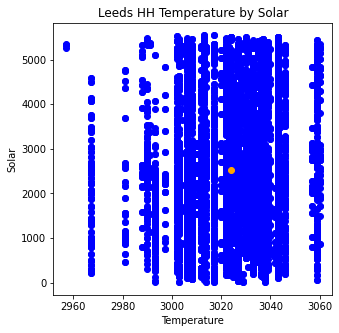

In [63]:
#Cluster Temp_1  Solar_1

ts_cluster =Leeds_HH_TS[[
'Temp_11',             
'Solar_1'                   
]]

clus_ts = ts_cluster.dropna()

kmeans =KMeans(n_clusters =1)
kmeans.fit(clus_ts)

labels = kmeans.predict(clus_ts)
centroids =kmeans.cluster_centers_

fig =plt.figure(figsize=(5,5))
#color =map(lambda x: colmap[x +1],labels)

plt.scatter(clus_ts['Temp_11'], clus_ts['Solar_1'], color ='blue')
#plt.xlim(0,30)
#plt.ylim(0,40)
plt.xlabel('Temperature') 
plt.ylabel('Solar') 
plt.title('Leeds HH Temperature by Solar') 
results_path = 'Leeds HH Temperature by Solar.png'

plt.scatter(centroids[:,0],centroids [:,1],color ='orange')
plt.savefig(results_path,bbox_inches="tight")
plt.show()

In [64]:
#print values
print(centroids)

[[3024.08897919 2535.3005237 ]]


In [73]:
#Split into Types
Leeds_HH_TS ['Canyon_Hot_NotSun'] = np.where(((Leeds_HH_TS['Temp_11'] >= 3024) & (Leeds_HH_TS['Solar_1'] <= 2535)),1,0) #Over 48193 less 2535 gap
Leeds_HH_TS ['Canyon_Cool_NotSun'] = np.where(((Leeds_HH_TS['Temp_11'] < 3024) & (Leeds_HH_TS['Solar_1'] <= 2535)),1,0) #Less 48193 less 2535 gap
Leeds_HH_TS ['Canyon_Hot_Sunny'] = np.where(((Leeds_HH_TS['Temp_11'] >= 3024) & (Leeds_HH_TS['Solar_1'] > 2535)),1,0) #Over 48193 greater 2535 gap
Leeds_HH_TS ['Canyon_Cool_Sunny'] = np.where(((Leeds_HH_TS['Temp_11'] < 3024) & (Leeds_HH_TS['Solar_1'] > 2535)),1,0)


In [74]:
#Output
Canyon_HH_Hot_NotSun = Leeds_HH_TS[Leeds_HH_TS['Canyon_Hot_NotSun'] == 1].copy()
Canyon_HH_Hot_NotSun.to_csv (r'./data/Ast_Canyon_HH_Hot_NotSun.csv', index = False, header=True)

Canyon_HH_Cool_NotSun = Leeds_HH_TS[Leeds_HH_TS['Canyon_Cool_NotSun'] == 1].copy()
Canyon_HH_Cool_NotSun.to_csv (r'./data/Ast_Canyon_HH_Cool_NotSun.csv', index = False, header=True)

Canyon_HH_Hot_Sunny = Leeds_HH_TS[Leeds_HH_TS['Canyon_Hot_Sunny'] == 1].copy()
Canyon_HH_Hot_Sunny.to_csv (r'./data/Ast_Canyon_HH_Hot_Sunny.csv', index = False, header=True)

Canyon_HH_Cool_Sunny = Leeds_HH_TS[Leeds_HH_TS['Canyon_Cool_Sunny'] == 1].copy()
Canyon_HH_Cool_Sunny.to_csv (r'./data/Ast_Canyon_HH_Cool_Sunny.csv', index = False, header=True)

## Clustering  Solar and surface temperature data Leeds Canyons

In [25]:
#Solar data

Leeds_S = pd.read_excel('./data/Leeds_Solar.xlsx'
              )
summary_d(Leeds_S)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45942 entries, 0 to 45941
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   fid      45942 non-null  int64  
 1   x        45942 non-null  float64
 2   y        45942 non-null  float64
 3   solar_1  45942 non-null  float64
dtypes: float64(3), int64(1)
memory usage: 1.4 MB


,fid,solar_1
0,23,5138.592773
1,23,1163.837036
2,23,986.565186
3,23,815.708191
4,23,620.652527
...,...,...
45937,10394,1103.968994
45938,10394,1103.968994
45939,10394,1897.060059
45940,10394,2577.340088


In [67]:
#Temperature data
Leeds_T = pd.read_excel('./data/Leeds_temp_Ast.xlsx'
              )
summary_d(Leeds_T)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45942 entries, 0 to 45941
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   fid     45942 non-null  int64  
 1   x       45942 non-null  float64
 2   y       45942 non-null  float64
 3   Temp_1  45789 non-null  float64
dtypes: float64(3), int64(1)
memory usage: 1.4 MB


In [68]:
##Merge data
Leeds_TS = pd.merge(Leeds_T,Leeds_S, how='inner', on=['fid','x','y'],sort=False)
summary_d(Leeds_TS)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45942 entries, 0 to 45941
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   fid      45942 non-null  int64  
 1   x        45942 non-null  float64
 2   y        45942 non-null  float64
 3   Temp_1   45789 non-null  float64
 4   solar_1  45942 non-null  float64
dtypes: float64(4), int64(1)
memory usage: 2.1 MB


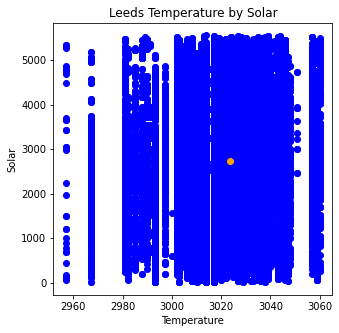

In [69]:
#Cluster Temp_1  Solar_1

ts_cluster =Leeds_TS[[
'Temp_1',             
'solar_1'                   
]]

clus_ts = ts_cluster.dropna()

kmeans =KMeans(n_clusters =1)
kmeans.fit(clus_ts)

labels = kmeans.predict(clus_ts)
centroids =kmeans.cluster_centers_

fig =plt.figure(figsize=(5,5))

plt.scatter(clus_ts['Temp_1'], clus_ts['solar_1'], color ='blue')
plt.xlabel('Temperature') 
plt.ylabel('Solar') 
plt.title('Leeds Temperature by Solar') 
results_path = 'Leeds Temperature by Solar.png'

plt.scatter(centroids[:,0],centroids [:,1],color ='orange')
plt.savefig(results_path,bbox_inches="tight")
plt.show()

In [70]:
#print values
print(centroids)

[[3023.66858853 2741.09828415]]


In [75]:
#Split into Types
Leeds_TS ['Canyon_Hot_NotSun'] = np.where(((Leeds_TS['Temp_1'] >= 3024) & (Leeds_TS['solar_1'] <= 2741)),1,0) #Over 48193 less 2535 gap
Leeds_TS ['Canyon_Cool_NotSun'] = np.where(((Leeds_TS['Temp_1'] < 3024) & (Leeds_TS['solar_1'] <= 2741)),1,0) #Less 48193 less 2535 gap
Leeds_TS ['Canyon_Hot_Sunny'] = np.where(((Leeds_TS['Temp_1'] >= 3024) & (Leeds_TS['solar_1'] > 2741)),1,0) #Over 48193 greater 2535 gap
Leeds_TS ['Canyon_Cool_Sunny'] = np.where(((Leeds_TS['Temp_1'] < 3024) & (Leeds_TS['solar_1'] > 2741)),1,0)


In [76]:
#Output
Canyon_Hot_NotSun = Leeds_TS[Leeds_TS['Canyon_Hot_NotSun'] == 1].copy()
Canyon_Hot_NotSun.to_csv (r'./data/Ast_Canyon_Hot_NotSun.csv', index = False, header=True)

Canyon_Cool_NotSun = Leeds_TS[Leeds_TS['Canyon_Cool_NotSun'] == 1].copy()
Canyon_Cool_NotSun.to_csv (r'./data/Ast_Canyon_Cool_NotSun.csv', index = False, header=True)

Canyon_Hot_Sunny = Leeds_TS[Leeds_TS['Canyon_Hot_Sunny'] == 1].copy()
Canyon_Hot_Sunny.to_csv (r'./data/Ast_Canyon_Hot_Sunny.csv', index = False, header=True)

Canyon_Cool_Sunny = Leeds_TS[Leeds_TS['Canyon_Cool_Sunny'] == 1].copy()
Canyon_Cool_Sunny.to_csv (r'./data/Ast_Canyon_Cool_Sunny.csv', index = False, header=True)